02 – Time Index Audit, Resampling, Early EDA, Data Quality

This notebook:

Loads scada_wide.parquet + signal_catalog.parquet

Wide→Long normalization

Time index audit (duplicates/gaps/median dt)

Resample to standard timebase (e.g., 5min)

Early EDA (missingness, distributions, sanity plots)

DQ scoring + monitoring confidence

Writes Parquet:

outputs/stages/scada_long.parquet

outputs/stages/scada_rs.parquet

outputs/stages/time_audit.parquet

outputs/stages/dq_report.parquet

In [234]:
import importlib
from pathlib import Path

import pandas as pd

import pv_fleet_health.scada_reshape as scada_reshape

importlib.reload(scada_reshape)
from pv_fleet_health.config import load_config_yaml
from pv_fleet_health.io import save_parquet
from pv_fleet_health.paths import Paths
from pv_fleet_health.scada_reshape import wide_to_long
from pv_fleet_health.timebase import compute_time_index_audit, resample_signals

ROOT = Path("..").resolve()
paths = Paths(ROOT)
paths.ensure()
cfg = load_config_yaml(str(ROOT / "config.yaml"))

In [235]:
scada_wide = pd.read_parquet(paths.stage_dir / "scada_wide.parquet")
signal_catalog = pd.read_parquet(paths.stage_dir / "signal_catalog.parquet")

print("Loaded scada_wide:", scada_wide.shape)
print("Loaded signal_catalog:", signal_catalog.shape)

# Optional: debug mode
if cfg.selected_plant is not None:
    keep_cols = [cfg.timestamp_col] + signal_catalog["raw_column_name"].tolist()
    scada_wide = scada_wide[keep_cols].copy()
    print("Filtered debug plant columns:", scada_wide.shape)

Loaded scada_wide: (2400, 244)
Loaded signal_catalog: (243, 12)


In [236]:
scada_long = wide_to_long(scada_wide, signal_catalog, cfg.timestamp_col)
print("scada_long:", scada_long.shape)
print(scada_long[["ts", "plant_name", "component_type", "canonical_signal", "value"]].head(5))

save_parquet(scada_long, str(paths.stage_dir / "scada_long.parquet"))

scada_long: (583200, 11)
                         ts                      plant_name component_type  \
0 2025-12-01 00:15:00+02:00  Solar Concept 3721 KWp Lexaina          array   
1 2025-12-01 00:30:00+02:00  Solar Concept 3721 KWp Lexaina          array   
2 2025-12-01 00:45:00+02:00  Solar Concept 3721 KWp Lexaina          array   
3 2025-12-01 01:00:00+02:00  Solar Concept 3721 KWp Lexaina          array   
4 2025-12-01 01:15:00+02:00  Solar Concept 3721 KWp Lexaina          array   

        canonical_signal     value  
0  ac_frequency_error_hz -1.890000  
1  ac_frequency_error_hz -0.643333  
2  ac_frequency_error_hz -1.434444  
3  ac_frequency_error_hz  0.094444  
4  ac_frequency_error_hz -2.107778  


In [237]:
time_audit = compute_time_index_audit(scada_long)
print("Time audit rows:", len(time_audit))
display(time_audit.sort_values("dup_frac", ascending=False).head(10))

save_parquet(time_audit, str(paths.stage_dir / "time_audit.parquet"))

Time audit rows: 1


plant_name                    min_ts  \
0  Solar Concept 3721 KWp Lexaina 2025-12-01 00:15:00+02:00   

                     max_ts  dup_frac  median_dt_min       n  
0 2025-12-26 00:00:00+02:00  0.995885           15.0  583200

In [238]:
scada_rs = resample_signals(scada_long, cfg)
print("scada_rs:", scada_rs.shape)
print(scada_rs.head())

save_parquet(scada_rs, str(paths.stage_dir / "scada_rs.parquet"))

scada_rs: (504000, 8)
                         ts  value_rs                      plant_name  \
0 2025-12-01 00:15:00+02:00 -1.890000  Solar Concept 3721 KWp Lexaina   
1 2025-12-01 00:30:00+02:00 -0.643333  Solar Concept 3721 KWp Lexaina   
2 2025-12-01 00:45:00+02:00 -1.434444  Solar Concept 3721 KWp Lexaina   
3 2025-12-01 01:00:00+02:00  0.094444  Solar Concept 3721 KWp Lexaina   
4 2025-12-01 01:15:00+02:00 -2.107778  Solar Concept 3721 KWp Lexaina   

  component_type component_id       canonical_signal unit     signal_type  
0          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
1          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
2          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
3          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
4          array            1  ac_frequency_error_hz   Hz  instant_or_avg  


                           value_rs                      plant_name  \
ts                                                                    
2025-12-01 00:15:00+02:00 -0.644000  Solar Concept 3721 KWp Lexaina   
2025-12-01 00:30:00+02:00 -0.611333  Solar Concept 3721 KWp Lexaina   
2025-12-01 00:45:00+02:00 -0.640667  Solar Concept 3721 KWp Lexaina   
2025-12-01 01:00:00+02:00 -0.639667  Solar Concept 3721 KWp Lexaina   
2025-12-01 01:15:00+02:00 -0.647000  Solar Concept 3721 KWp Lexaina   
2025-12-01 01:30:00+02:00 -0.644333  Solar Concept 3721 KWp Lexaina   
2025-12-01 01:45:00+02:00 -0.643667  Solar Concept 3721 KWp Lexaina   
2025-12-01 02:00:00+02:00 -0.645333  Solar Concept 3721 KWp Lexaina   
2025-12-01 02:15:00+02:00 -0.646667  Solar Concept 3721 KWp Lexaina   
2025-12-01 02:30:00+02:00 -0.632000  Solar Concept 3721 KWp Lexaina   

                          component_type component_id canonical_signal unit  \
ts                                                                  

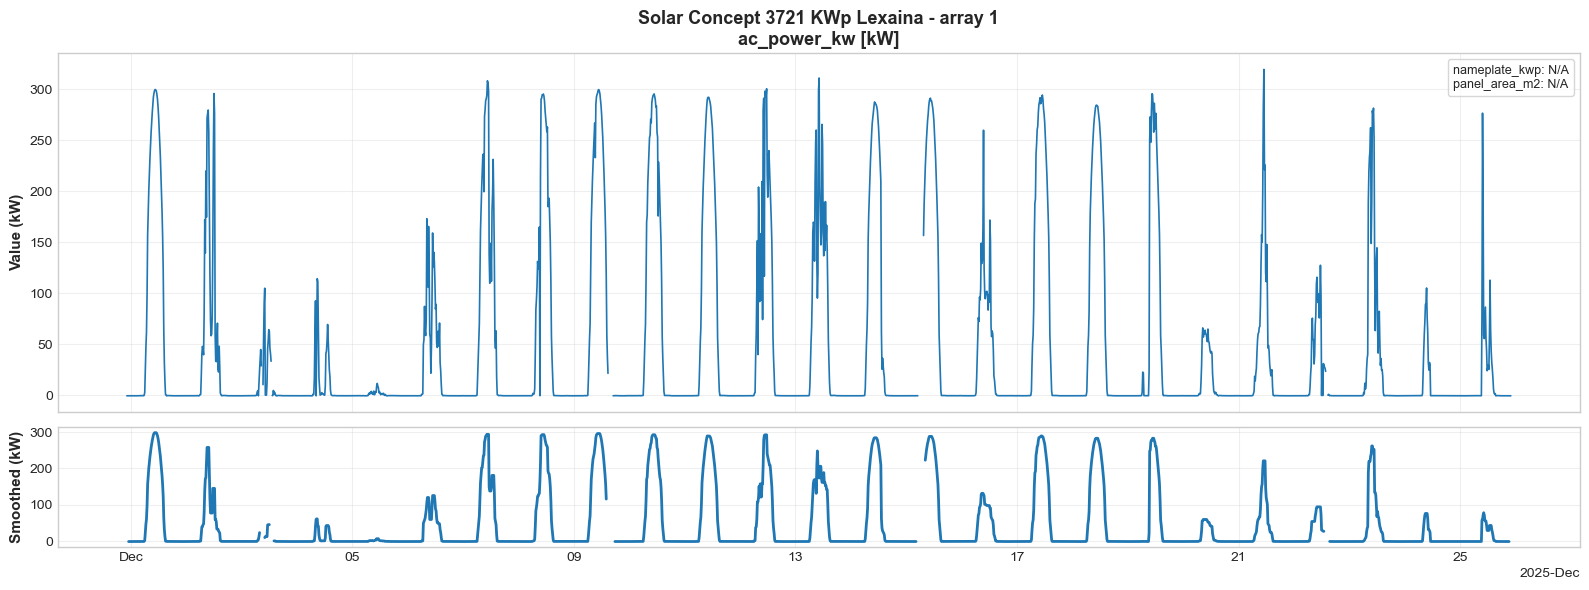

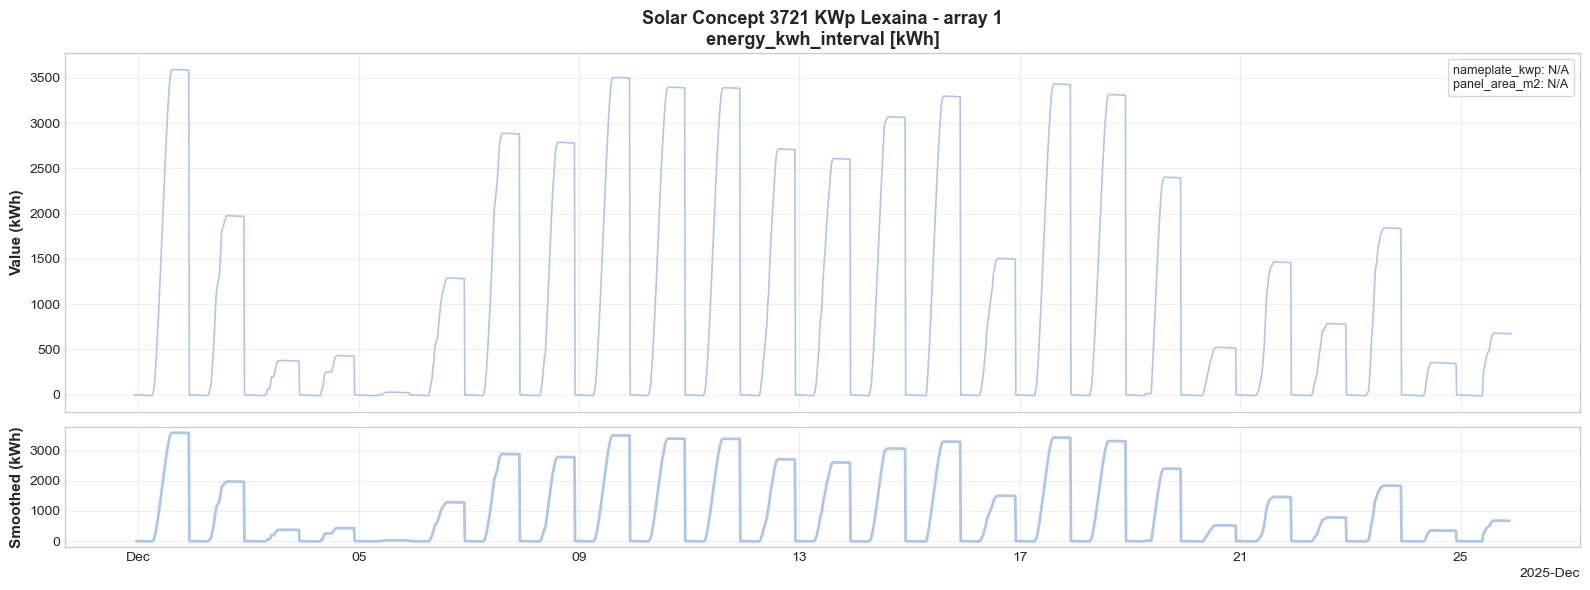

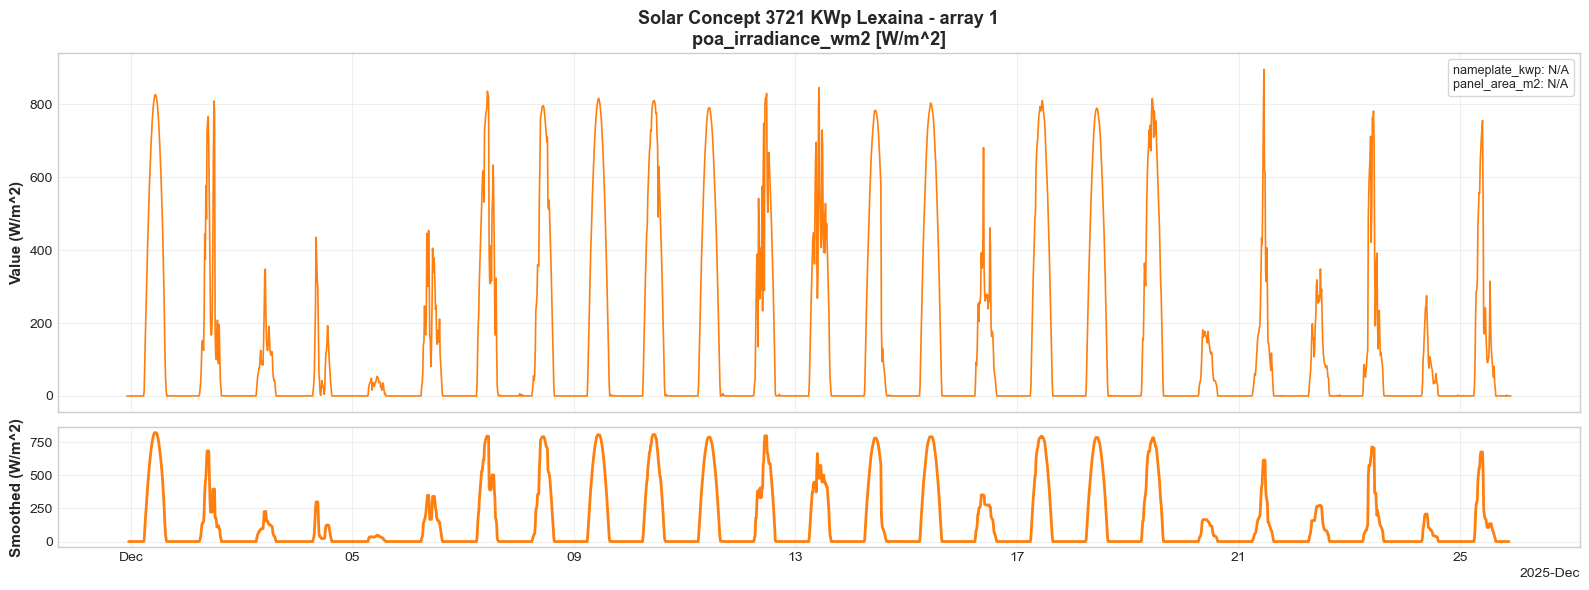

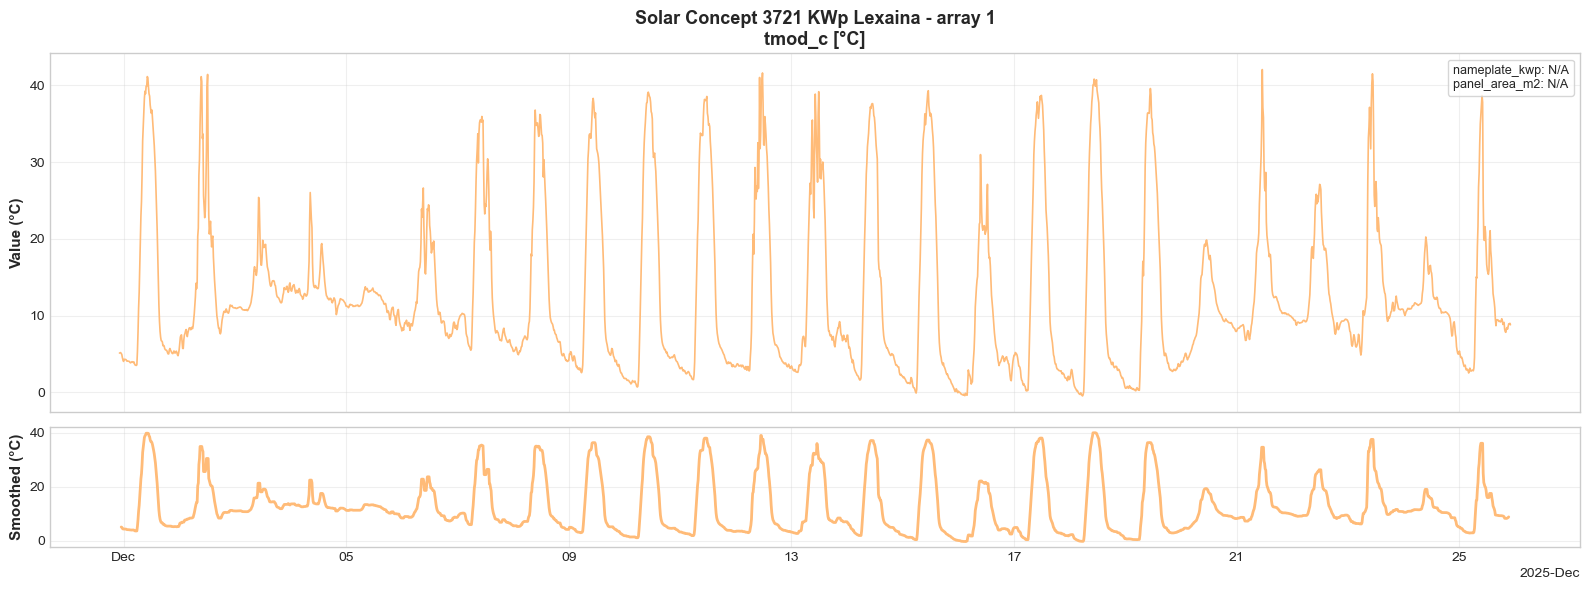

In [110]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd


def _extract_signal_value(df, signal_name):
    mask = df["canonical_signal"] == signal_name
    values = df.loc[mask, "value_rs"].dropna()
    if values.empty:
        return None
    return values.median()


def _normalize_key_signals(key_signals):
    """Normalize key_signals to a list or return None."""
    if key_signals is None:
        return None
    if isinstance(key_signals, str):
        return [key_signals]
    return list(key_signals)


def _filter_by_signals(df, key_signals):
    """Filter dataframe to only include specified signals."""
    if key_signals is None or len(key_signals) == 0:
        return df
    return df[df["canonical_signal"].isin(key_signals)]


def _ensure_time_index(df):
    """Ensure the dataframe has a datetime index on 'ts' column."""
    if "ts" in df.columns and df.index.name != "ts":
        df = df.set_index("ts")
    return df


def _fill_missing_metadata(df, meta_columns):
    """Forward-fill missing metadata columns."""
    for col in meta_columns:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()
    return df


# Define metadata columns that should be consistent within a component
META_COLUMNS = ["nameplate_kwp", "panel_area_m2", "plant_name", "component_type", "component_id"]


def filter_scada_rs(
    scada_rs,
    plant_name=None,
    component_type=None,
    component_id=None,
    n=10,
    key_signals=None,
):
    df = scada_rs.copy()

    # Only filter by each key if it is not None
    if plant_name is not None:
        df = df[df["plant_name"] == plant_name]
    if component_type is not None:
        df = df[df["component_type"] == component_type]
    if component_id is not None:
        df = df[df["component_id"] == component_id]

    key_signals = _normalize_key_signals(key_signals)
    df = _filter_by_signals(df, key_signals)
    df = _ensure_time_index(df)

    # Only assert uniqueness if filtered by that key
    if plant_name is not None:
        assert df["plant_name"].nunique() == 1, "plant_name is not unique in filtered result"
    if "nameplate_kwp" in df.columns:
        assert df["nameplate_kwp"].nunique() == 1, "nameplate_kwp is not unique in filtered result"
    if "panel_area_m2" in df.columns:
        assert df["panel_area_m2"].nunique() == 1, "panel_area_m2 is not unique in filtered result"

    df = _fill_missing_metadata(df, META_COLUMNS)

    print(df.head(n))
    print(df.columns)
    print(df["canonical_signal"].unique())
    return df


def plot_scada_signals(df, rolling_window=7):
    plt.style.use("seaborn-v0_8-whitegrid")

    required = ["value_rs", "canonical_signal", "unit"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    signals = sorted(df["canonical_signal"].unique())
    palette = plt.cm.tab20.colors
    color_map = {sig: palette[i % len(palette)] for i, sig in enumerate(signals)}

    for sig, grp in df.groupby("canonical_signal"):
        unit = grp["unit"].iloc[0]
        base_color = color_map[sig]
        meta = grp.iloc[0]

        fig, (ax1, ax2) = plt.subplots(
            2,
            1,
            figsize=(16, 6),
            sharex=True,
            gridspec_kw={"height_ratios": [3, 1]},
        )

        ax1.plot(grp.index, grp["value_rs"], linestyle="-", color=base_color, linewidth=1.2)
        ax1.set_title(
            f"{meta['plant_name']} - {meta['component_type']} {meta['component_id']}\n"
            f"{sig} [{unit}]",
            fontsize=13,
            weight="bold",
        )
        ax1.set_ylabel(f"Value ({unit})", fontsize=11, weight="bold")
        ax1.grid(True, alpha=0.3)

        rolling = grp["value_rs"].rolling(window=rolling_window, center=True).median()
        ax2.plot(grp.index, rolling, linestyle="-", color=base_color, linewidth=2)
        ax2.set_ylabel(f"Smoothed ({unit})", fontsize=11, weight="bold")
        ax2.grid(True, alpha=0.3)

        legend_text = (
            f"nameplate_kwp: {meta.get('nameplate_kwp', 'N/A')}\n"
            f"panel_area_m2: {meta.get('panel_area_m2', 'N/A')}"
        )
        ax1.legend(
            [legend_text],
            loc="upper right",
            frameon=True,
            fontsize=9,
            handlelength=0,
            handletextpad=0,
        )

        ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

        plt.tight_layout()
        plt.show()


# Usage
df_filtered = filter_scada_rs(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    component_id="1",
    key_signals=["ac_power_kw", "poa_irradiance_wm2", "tmod_c", "energy_kwh_interval"],
)

plot_scada_signals(df_filtered, rolling_window=7)

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


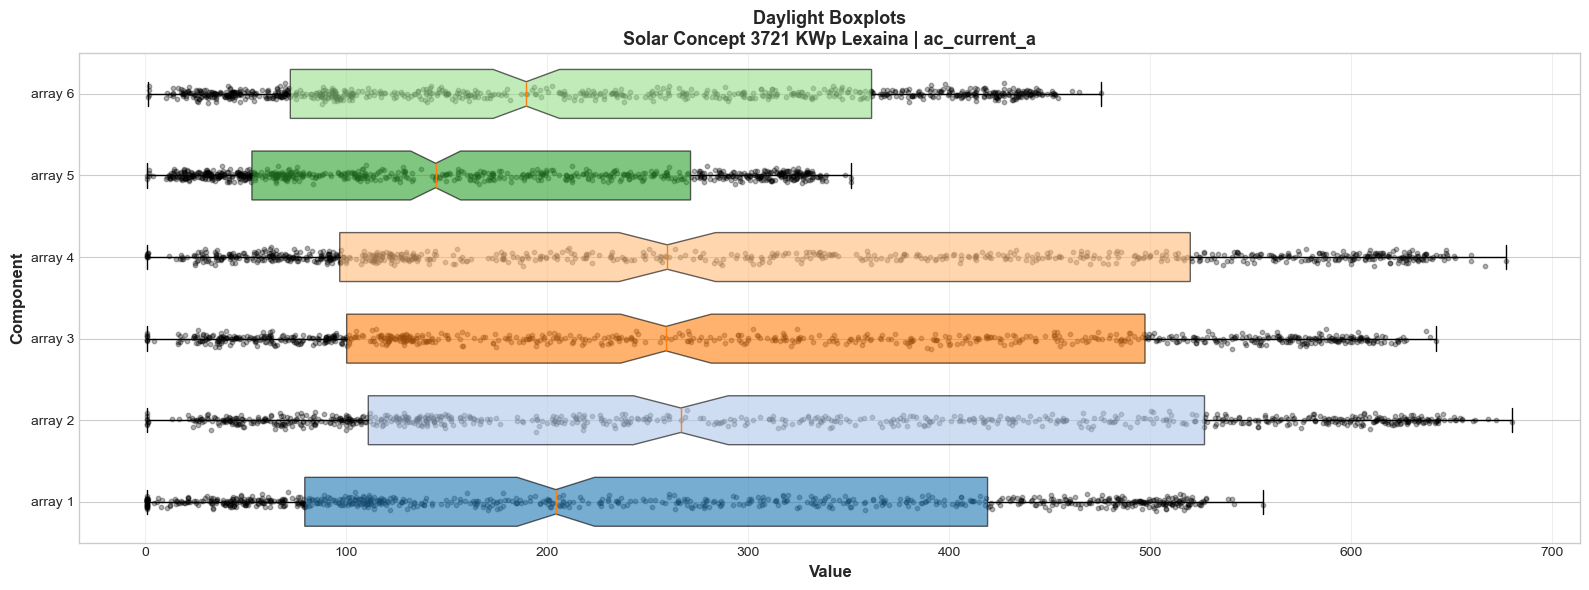

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


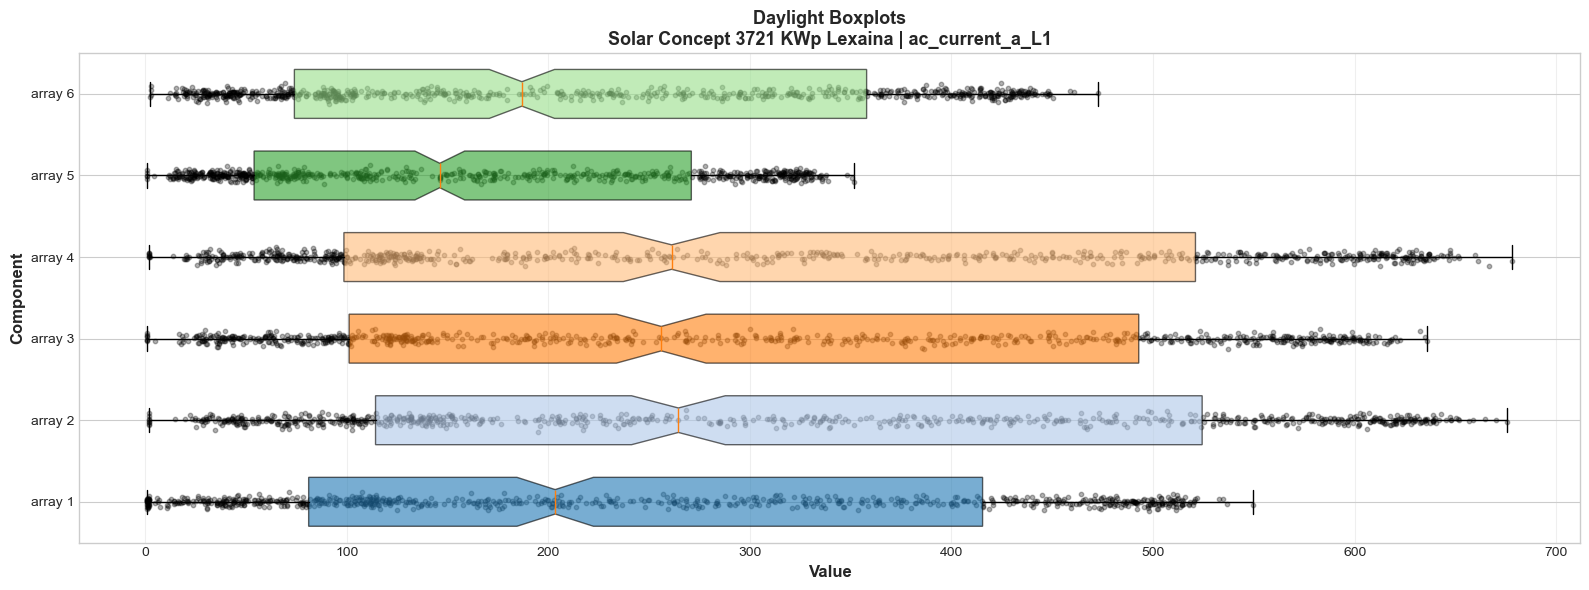

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


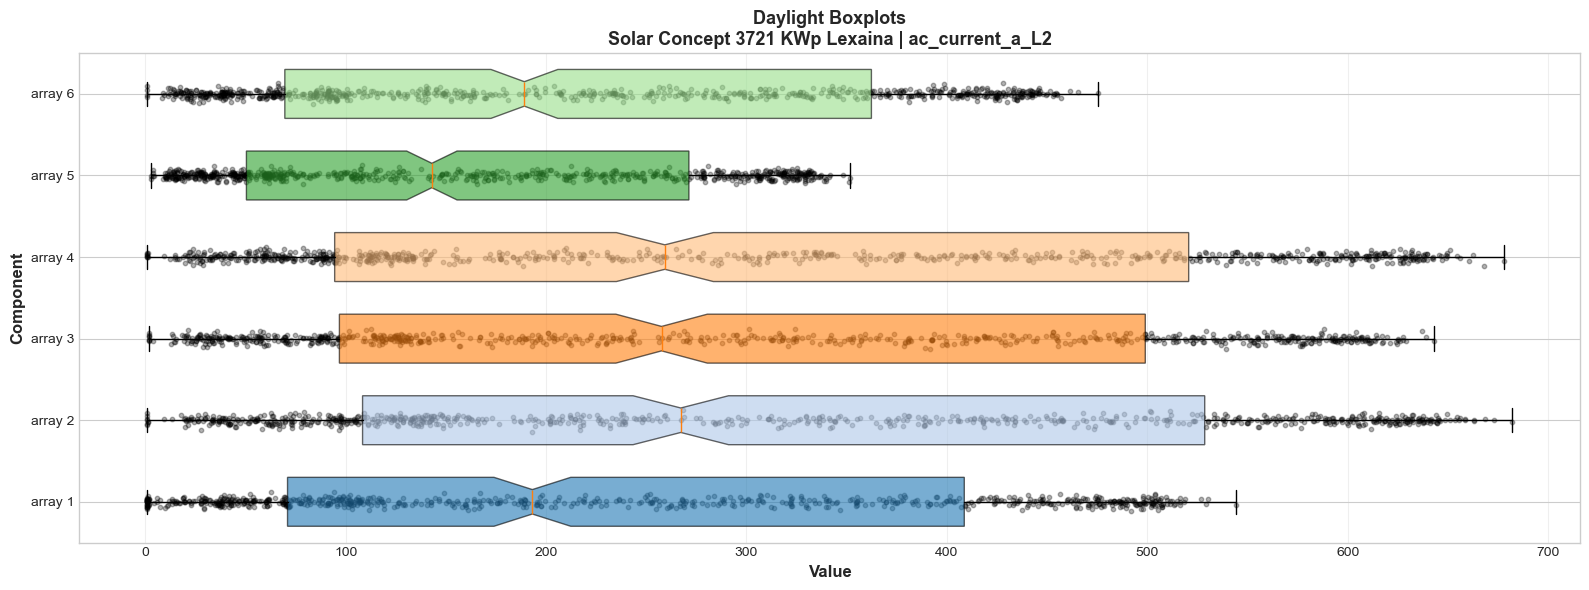

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


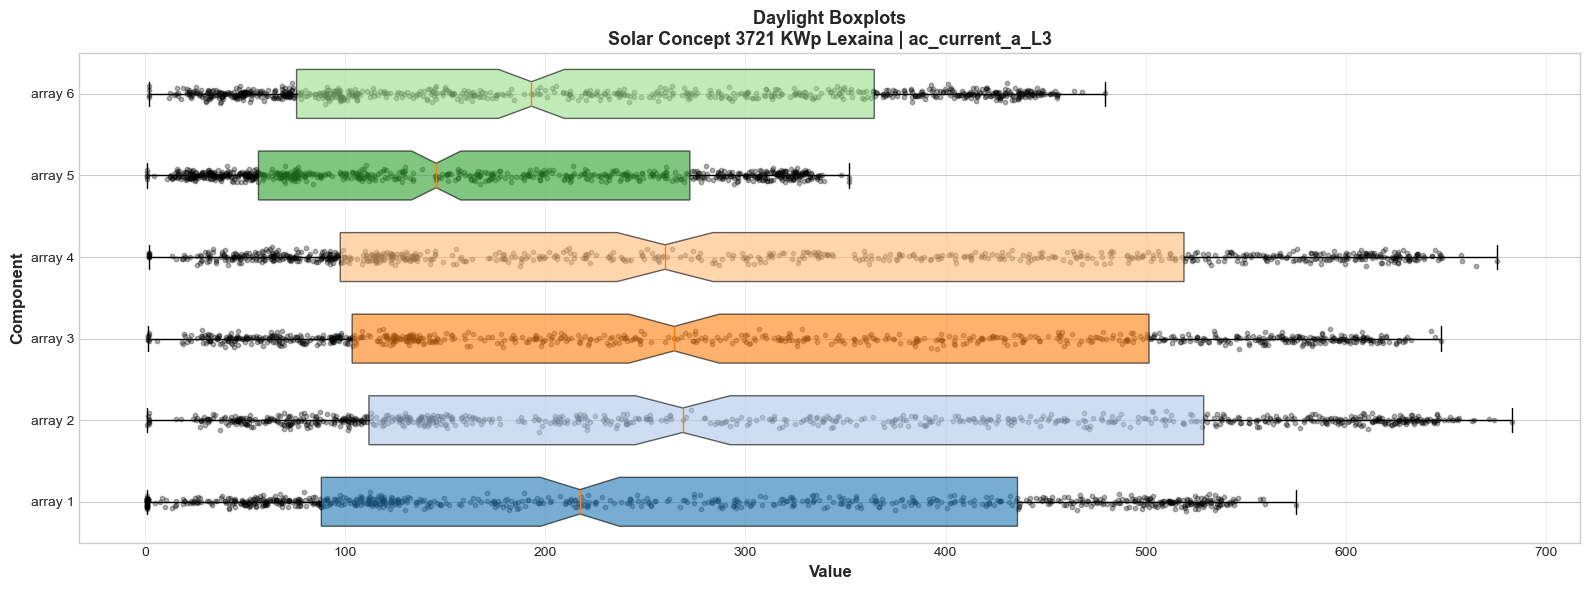

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


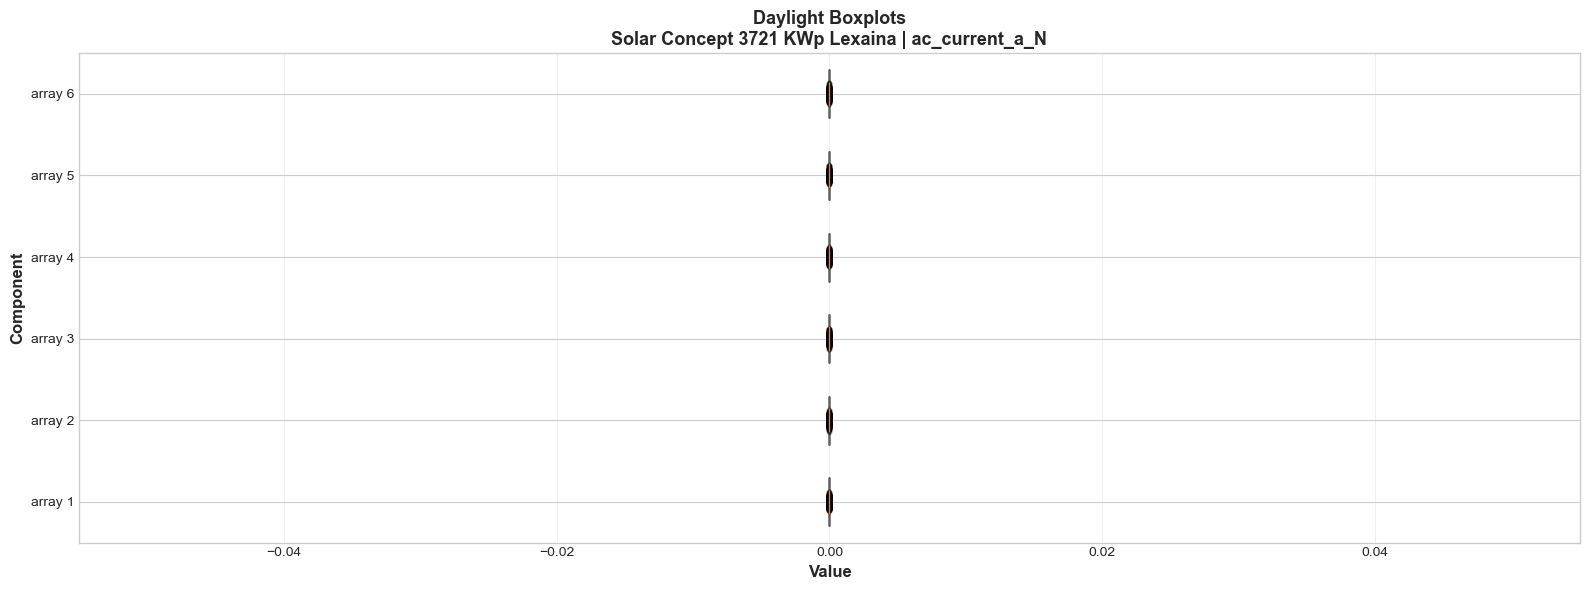

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


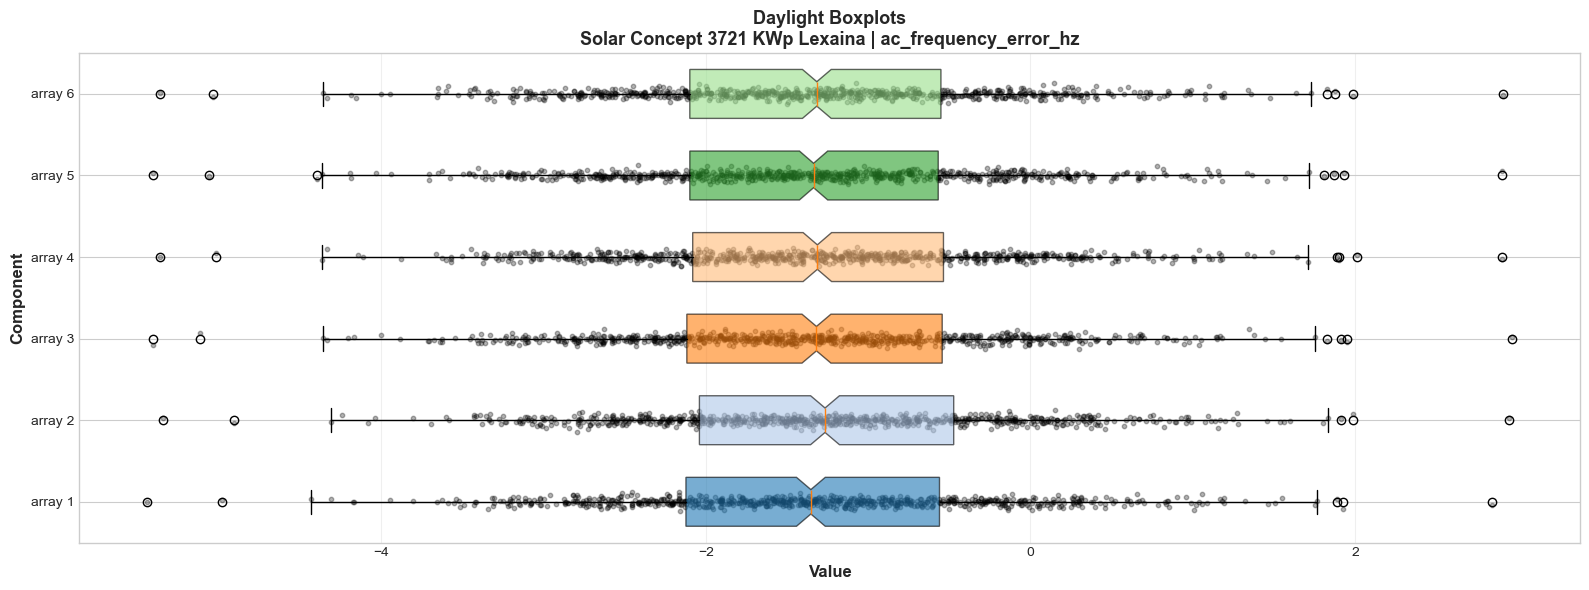

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


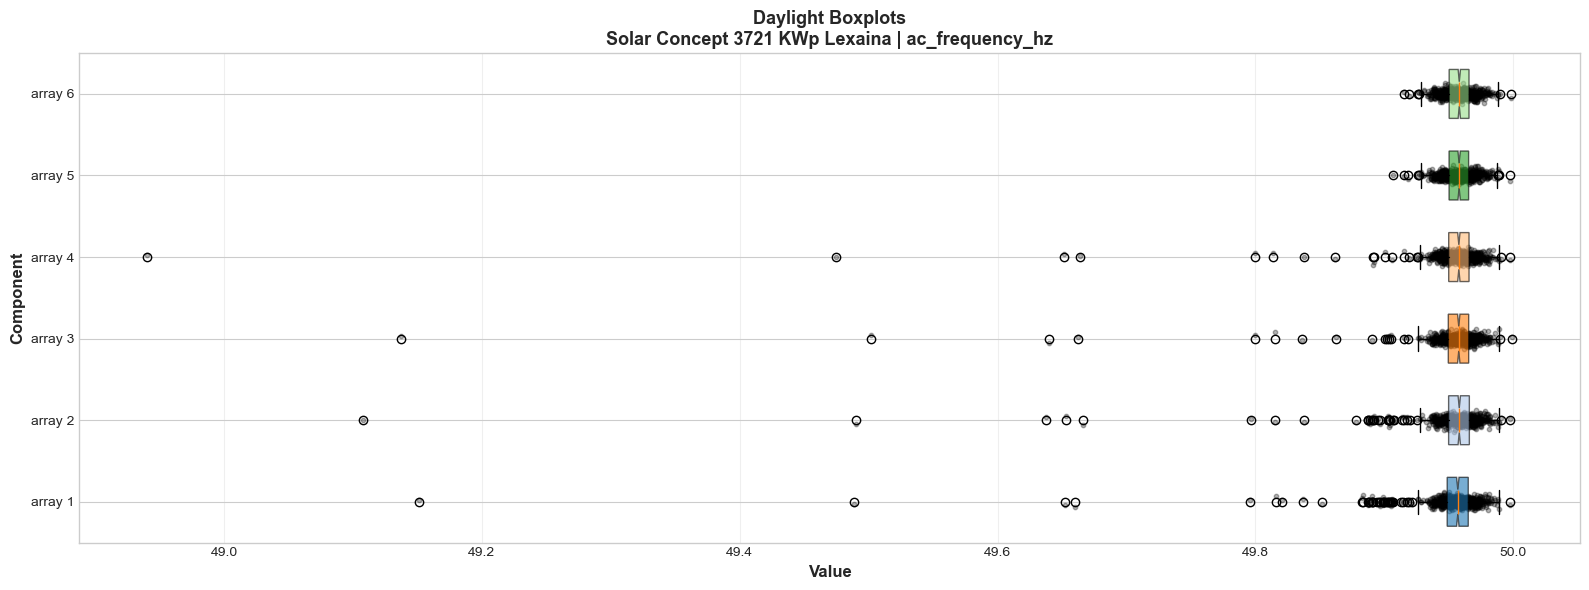

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


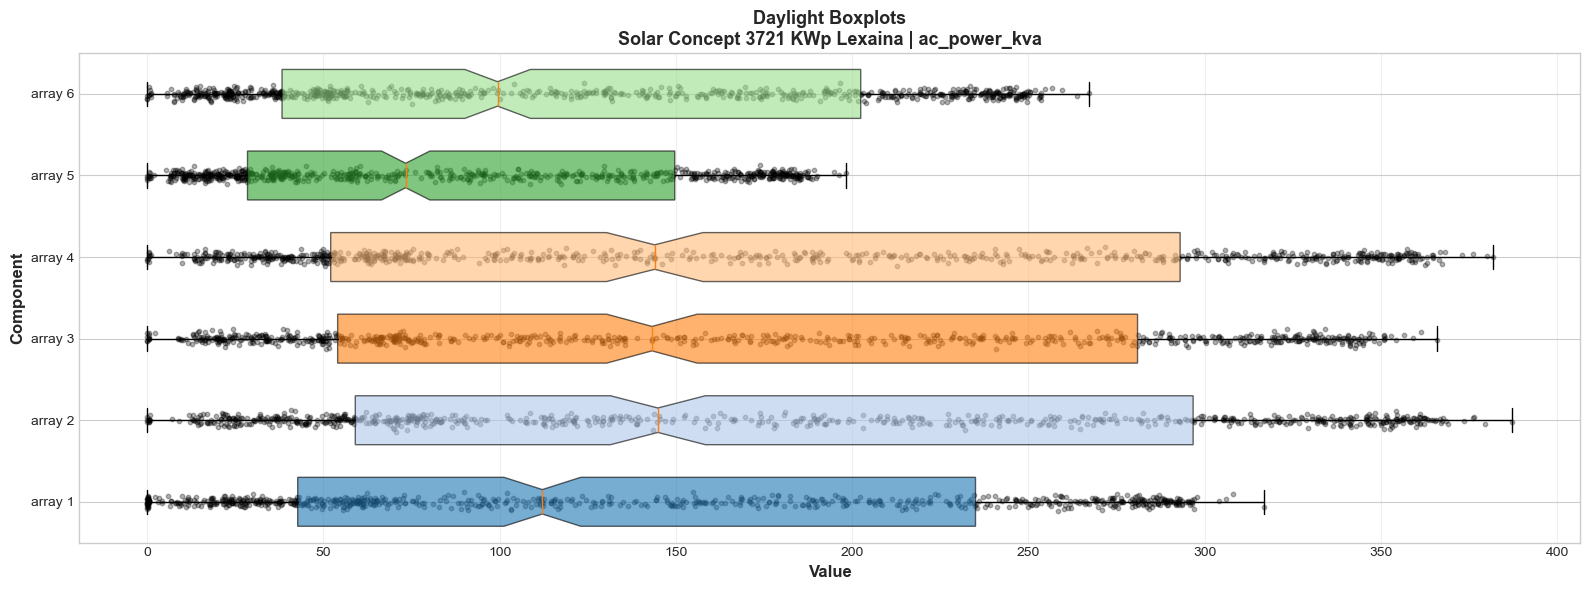

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


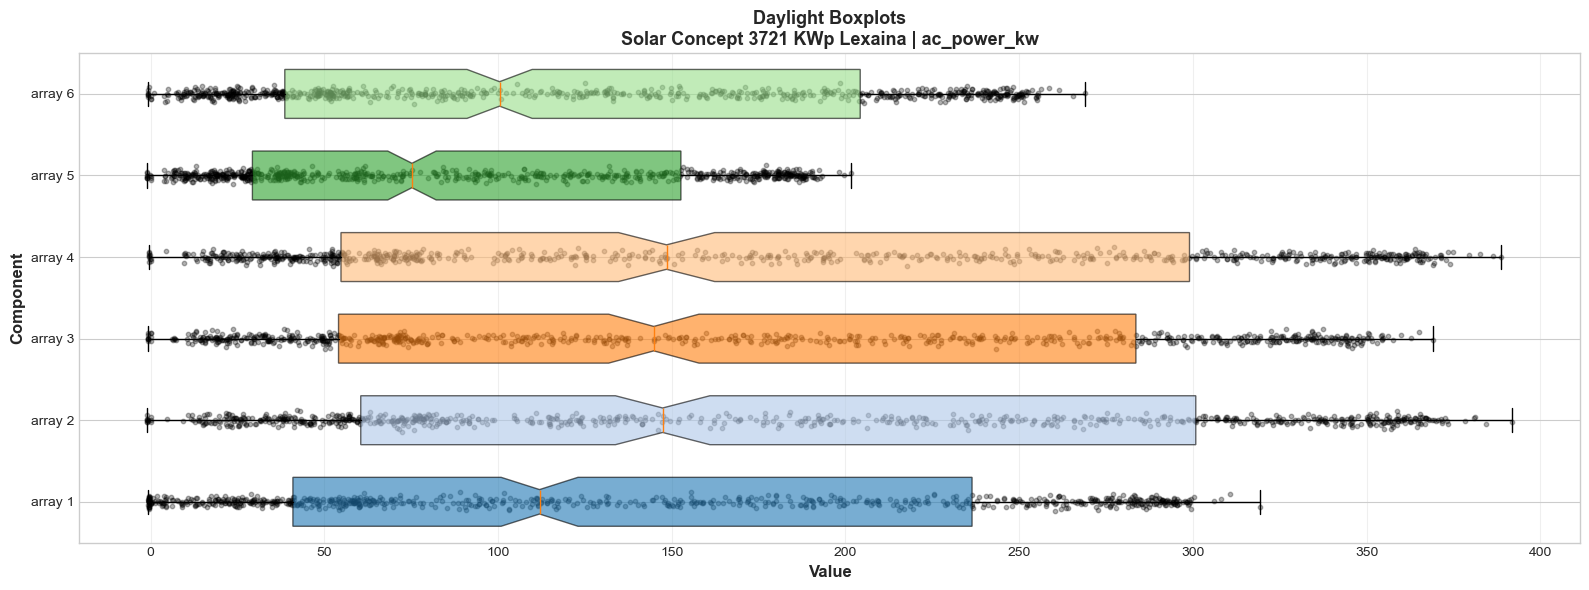

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


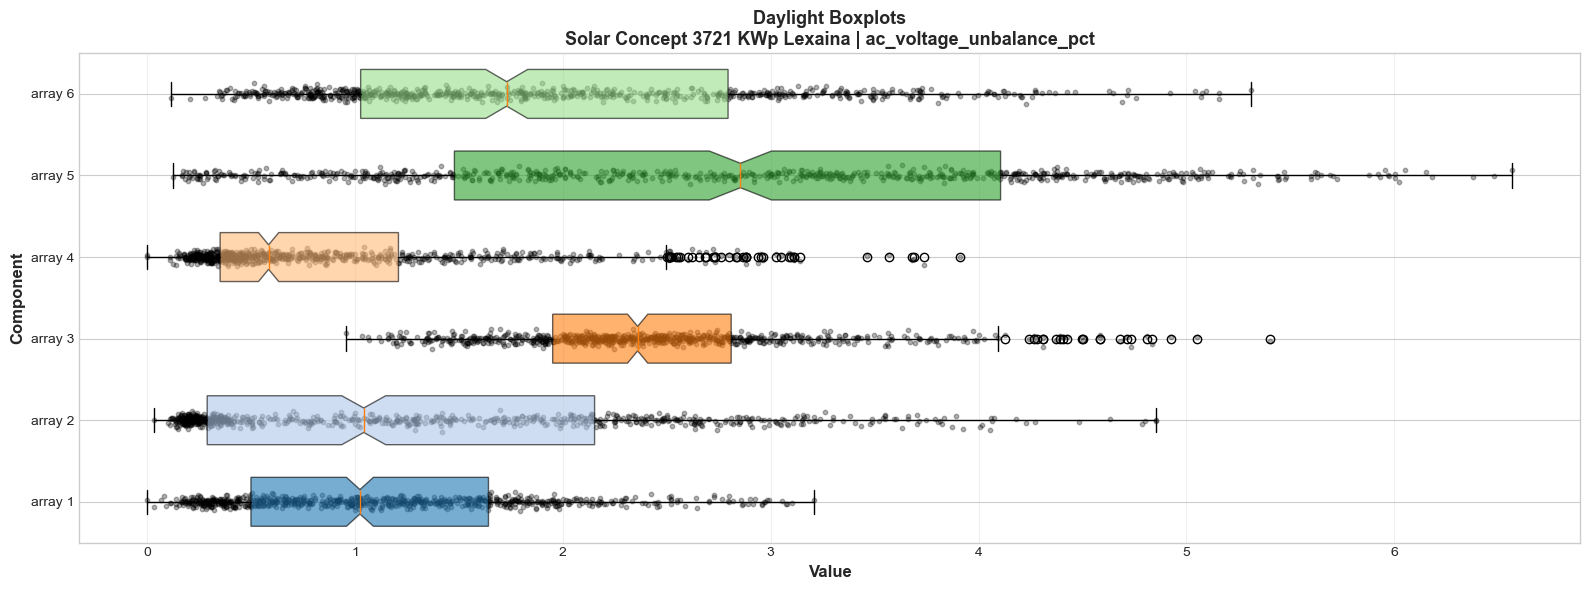

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


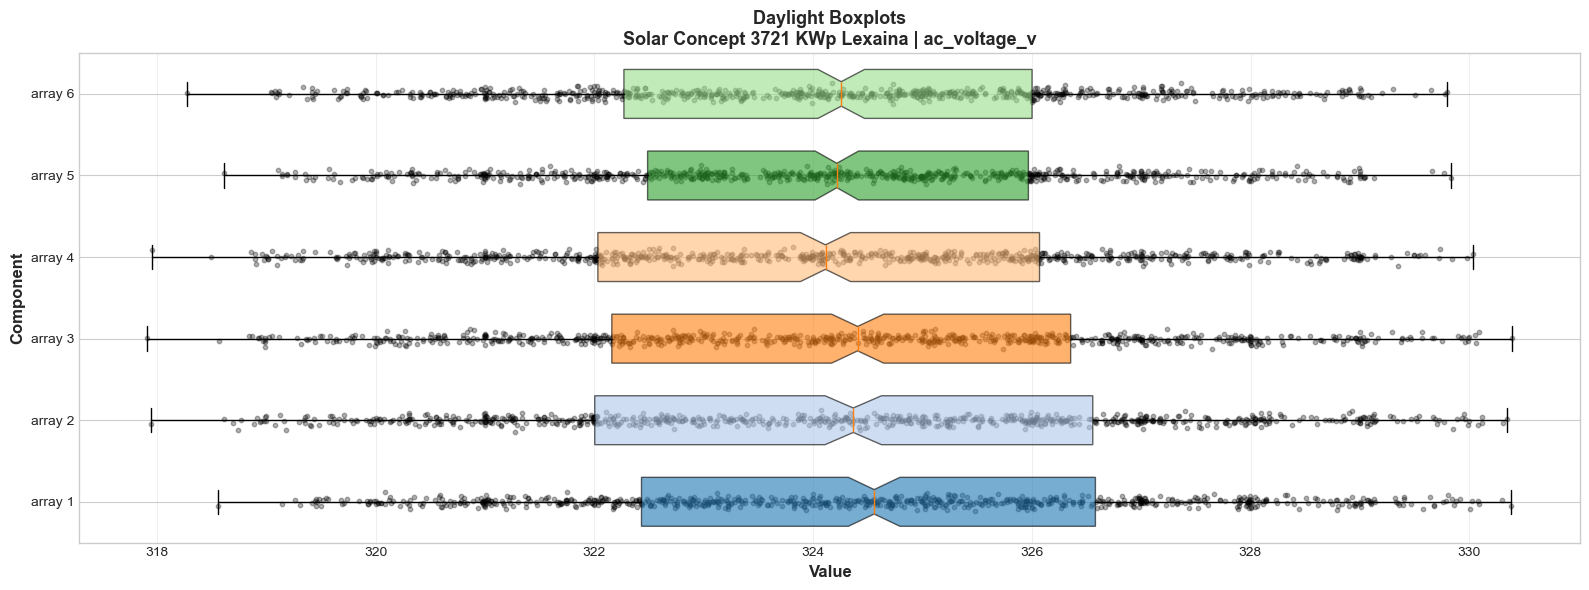

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


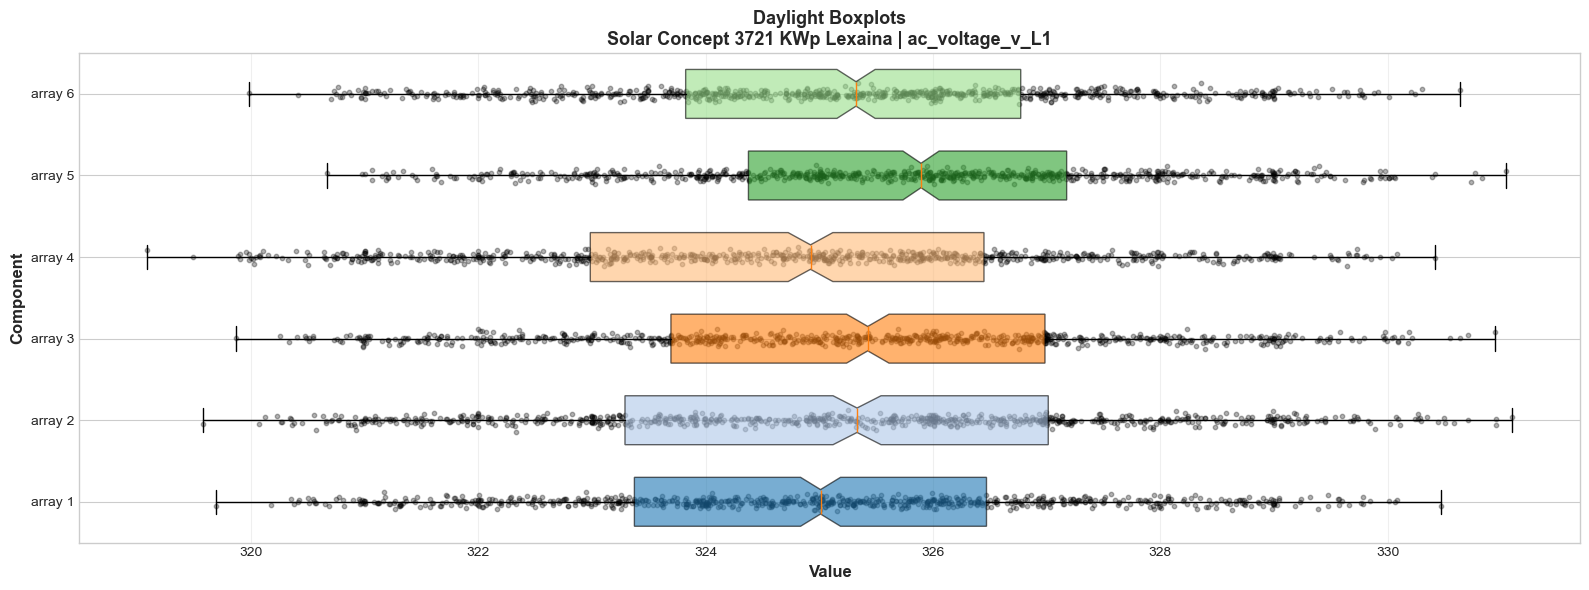

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


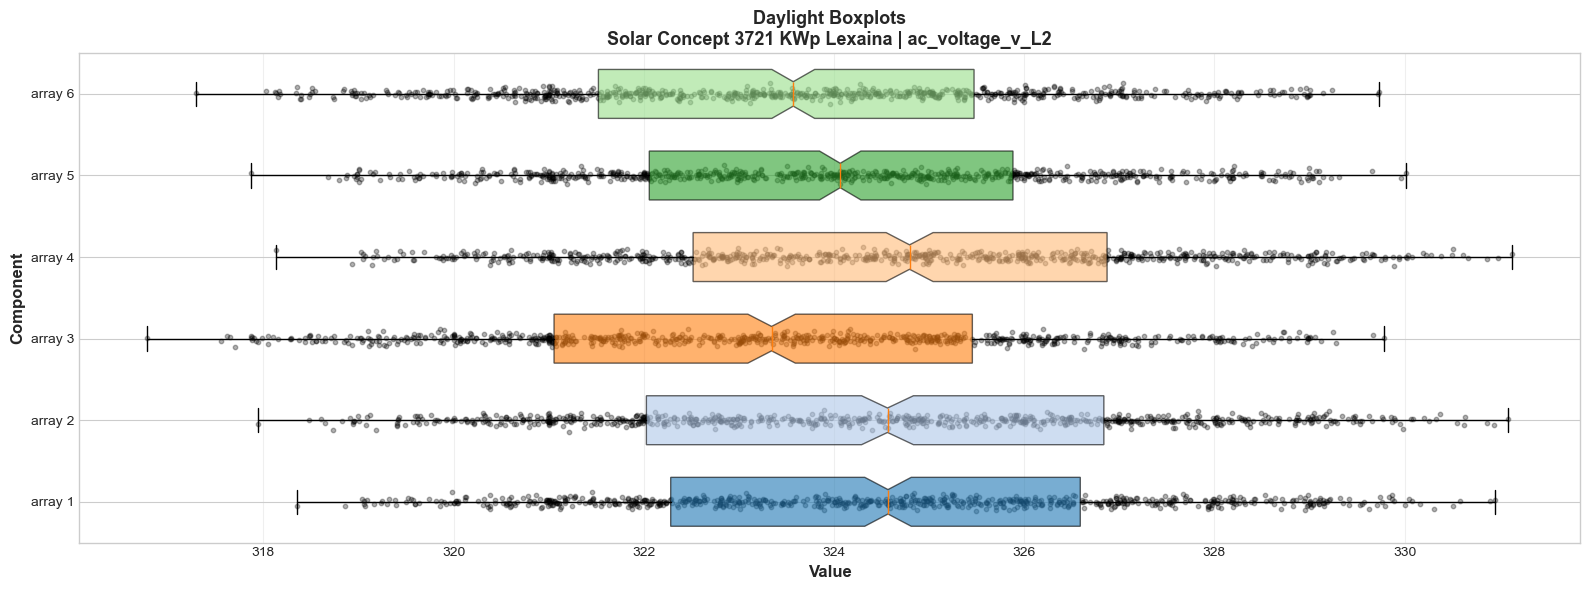

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


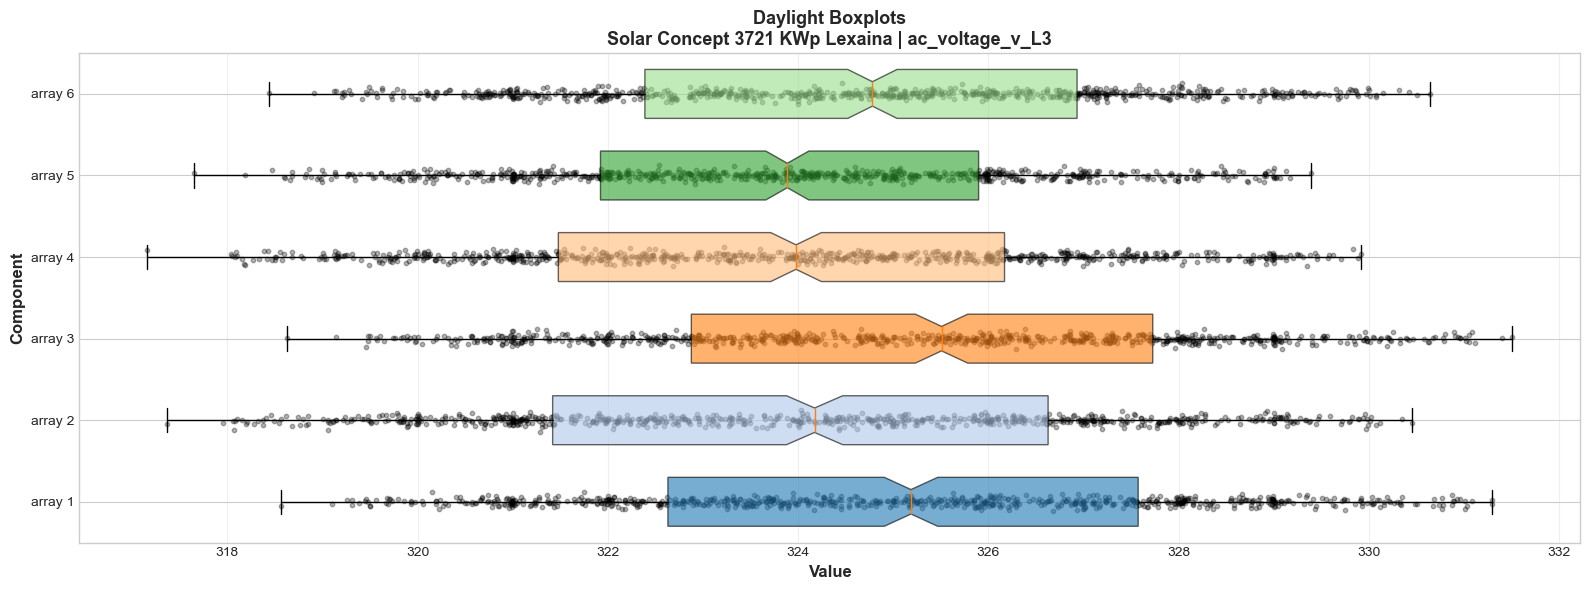

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


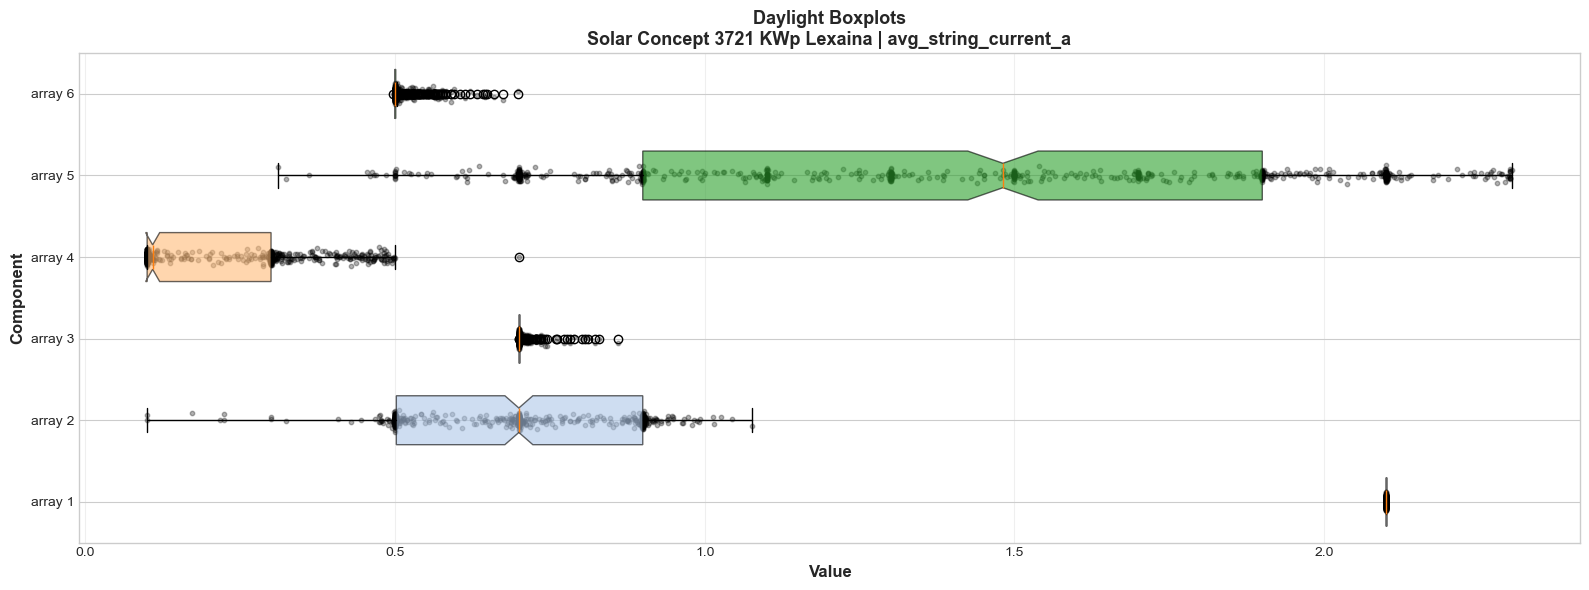

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


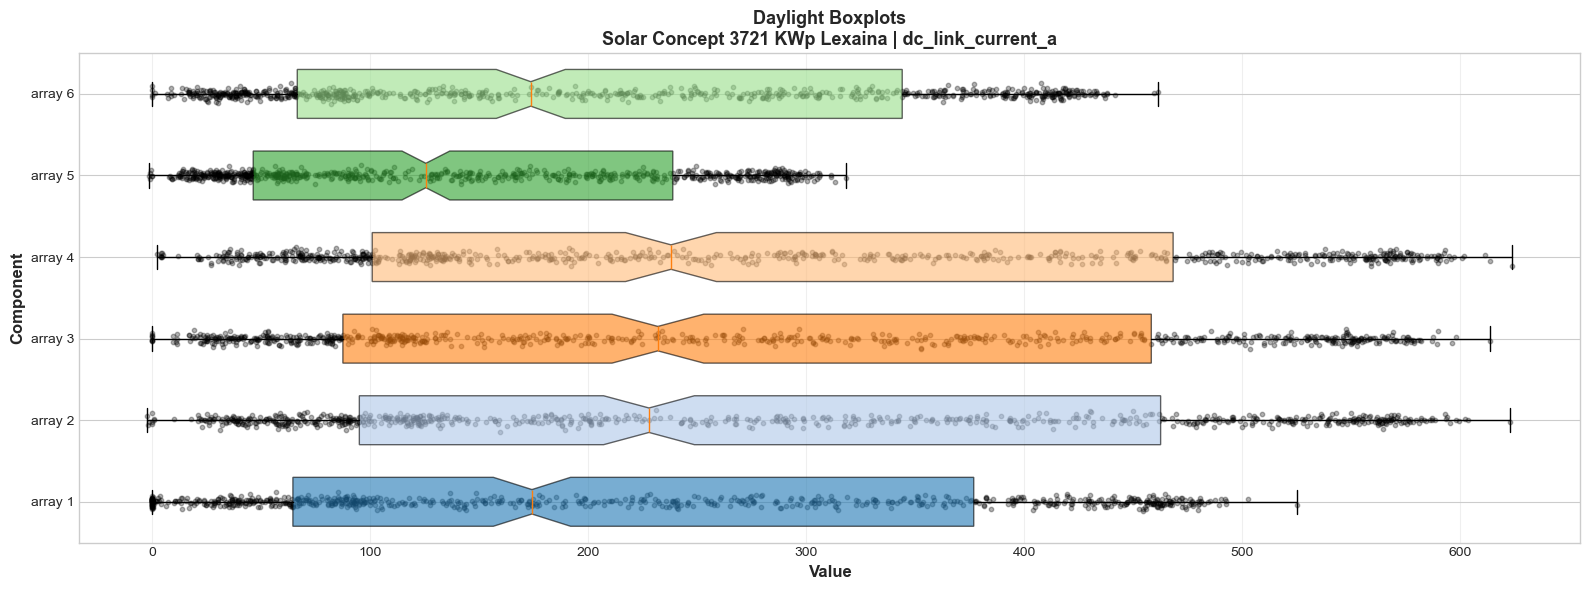

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


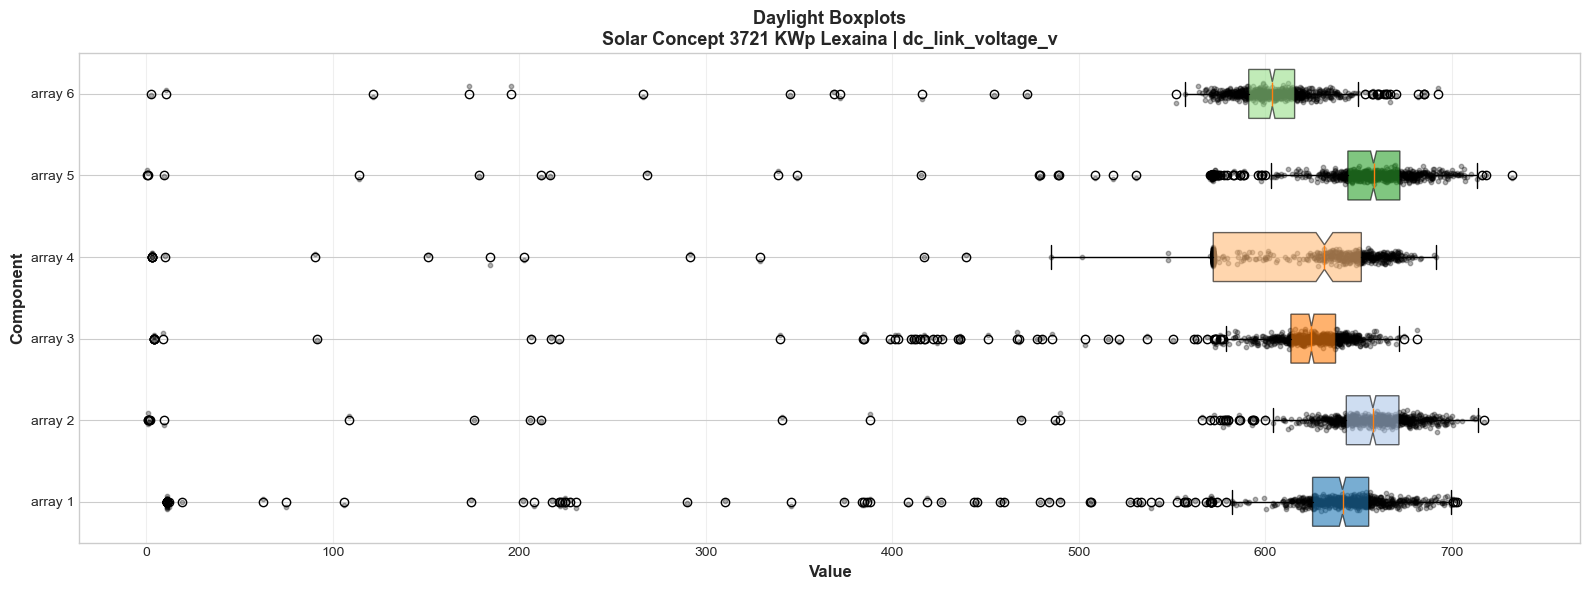

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


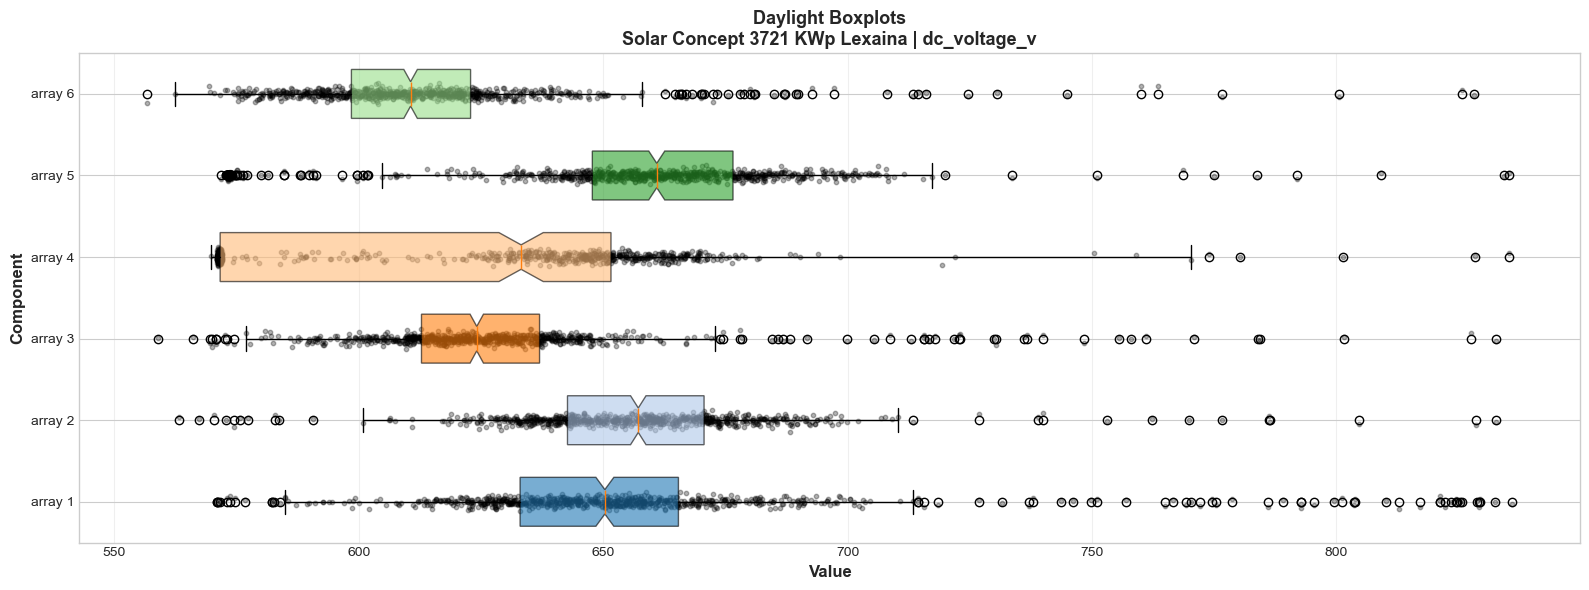

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


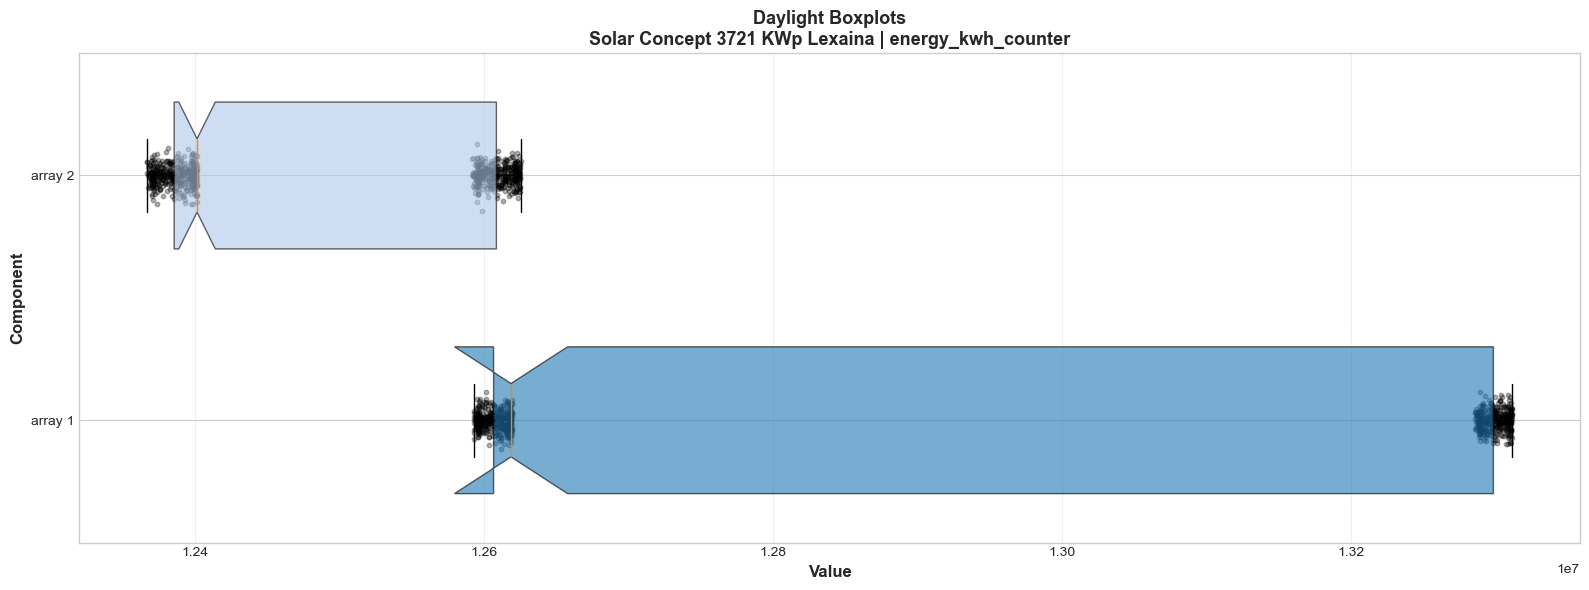

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


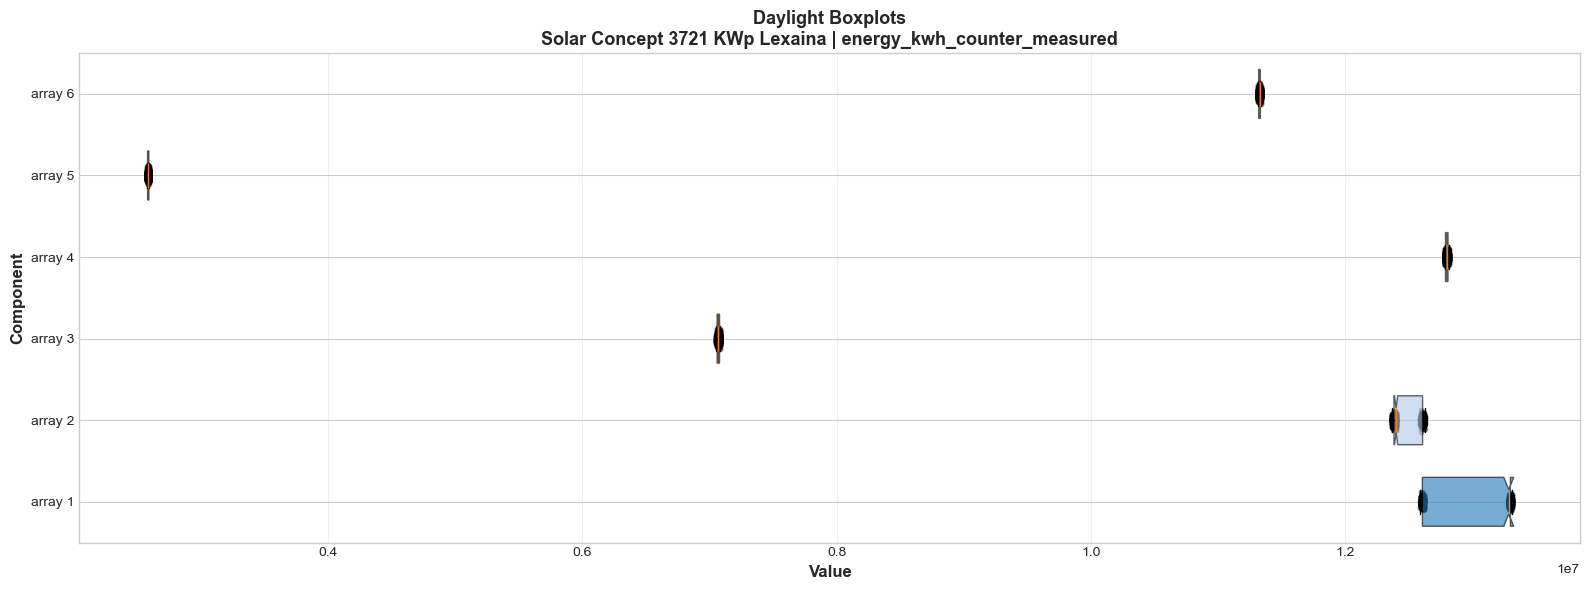

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


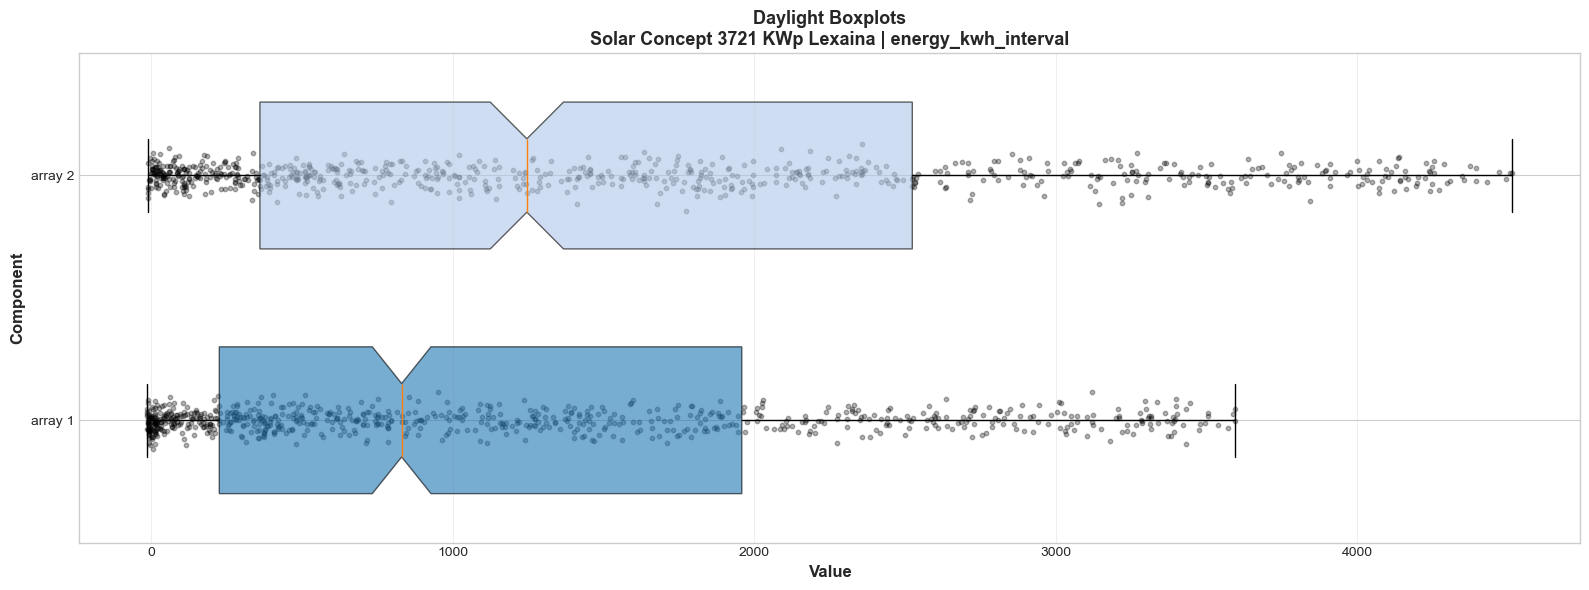

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


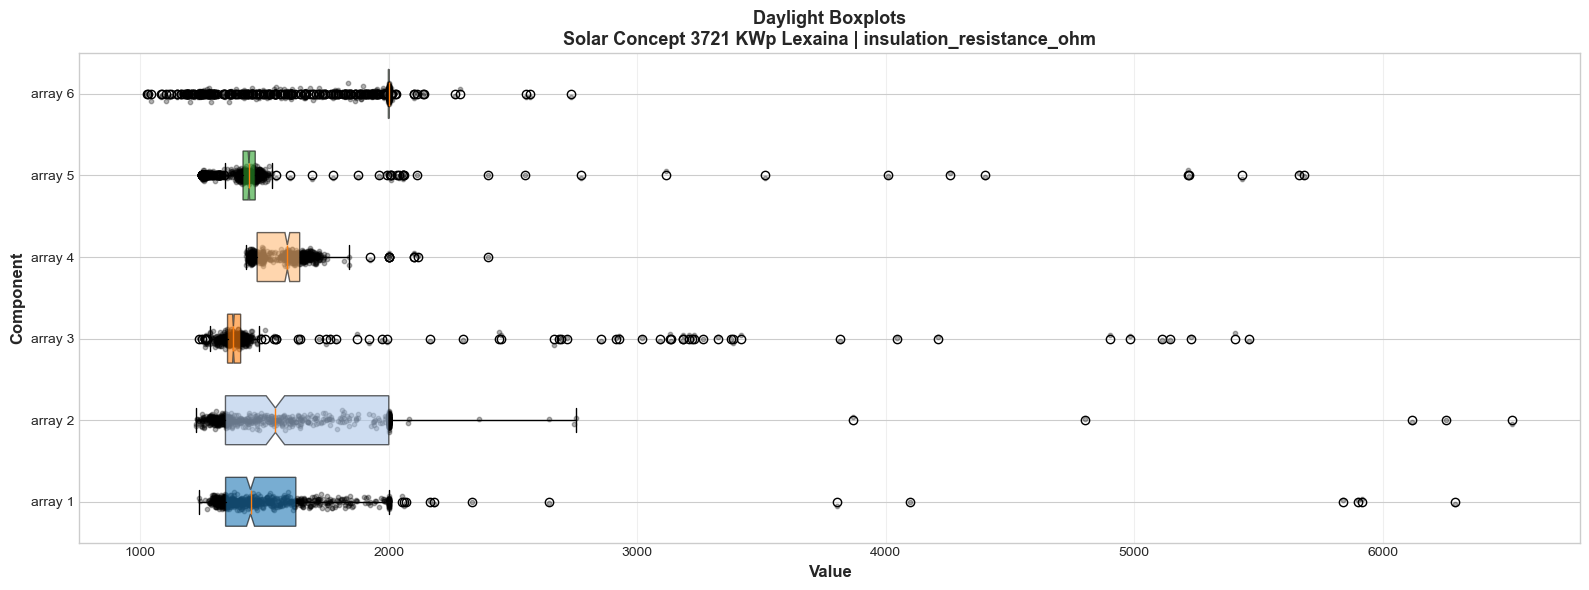

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


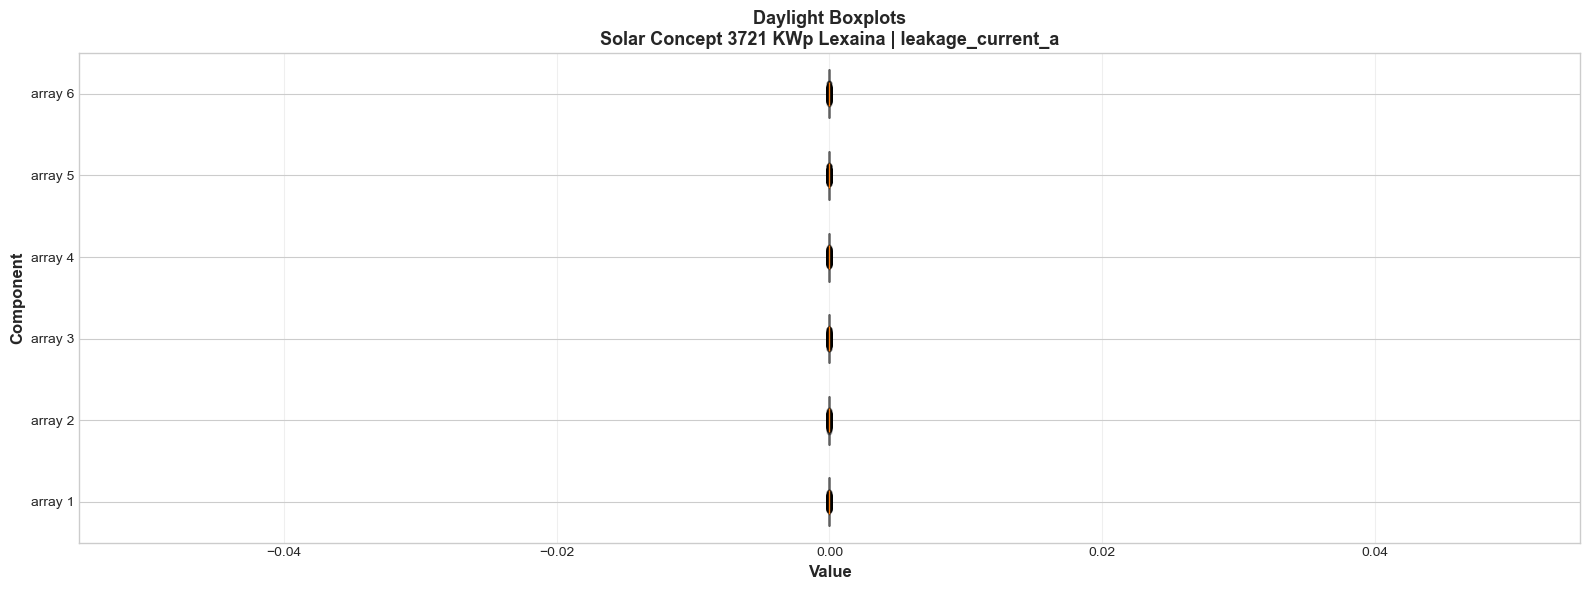

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


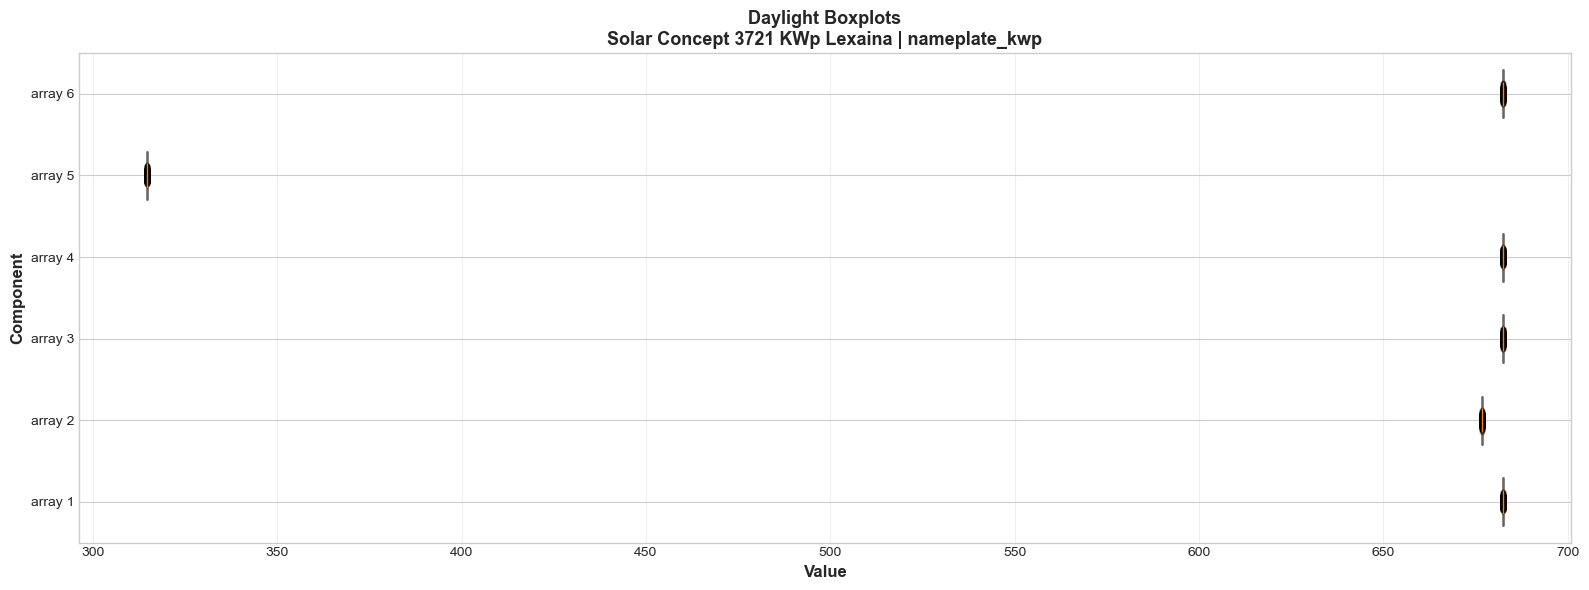

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


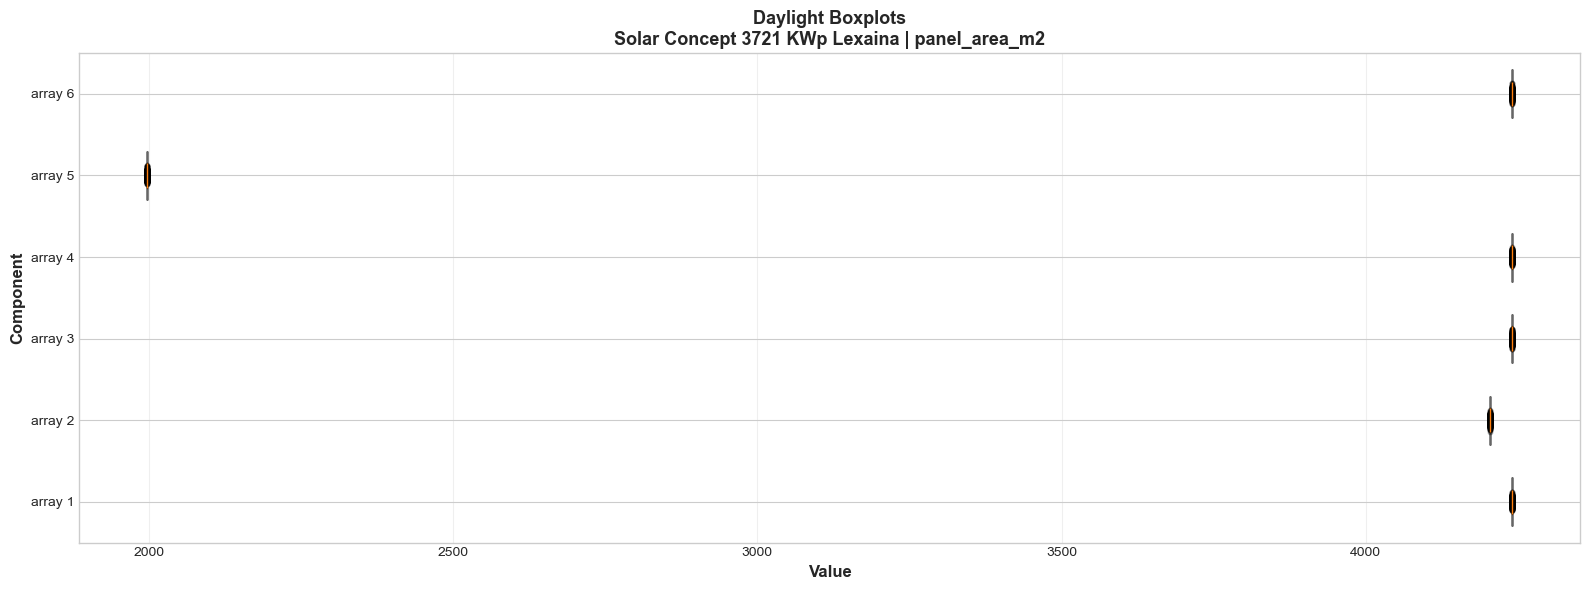

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


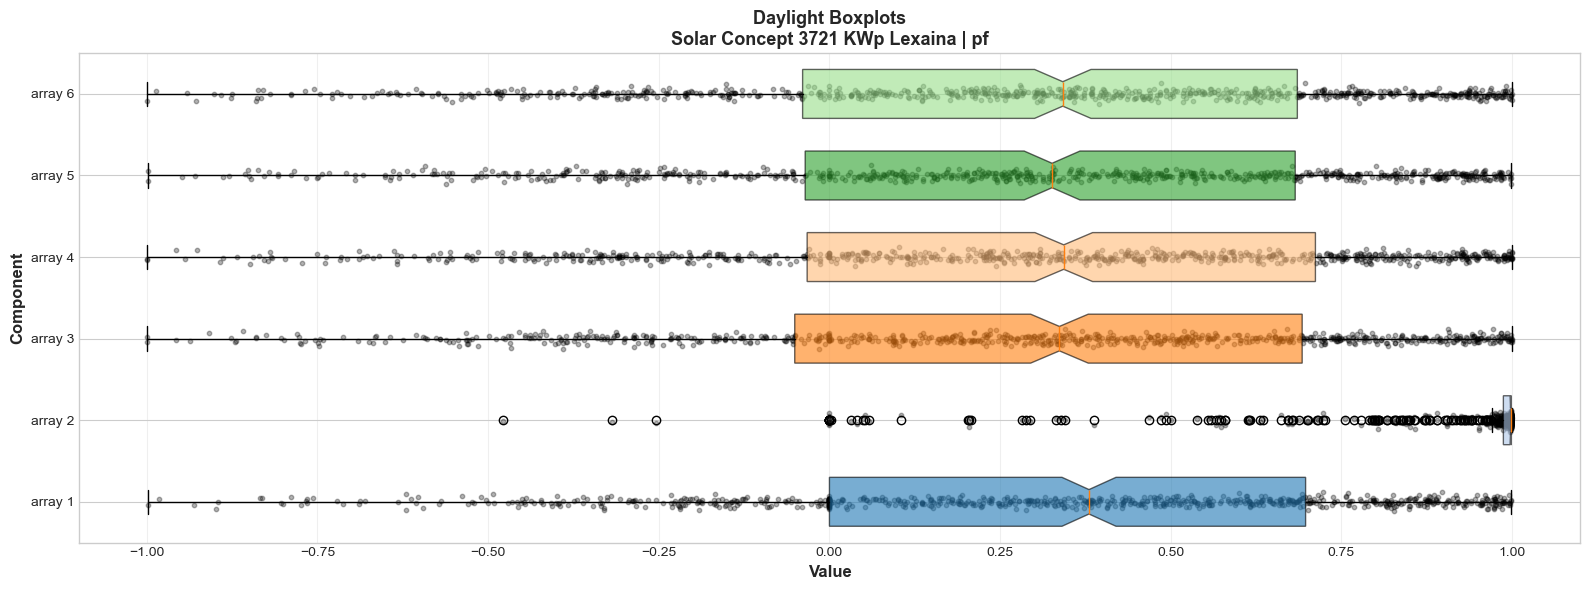

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


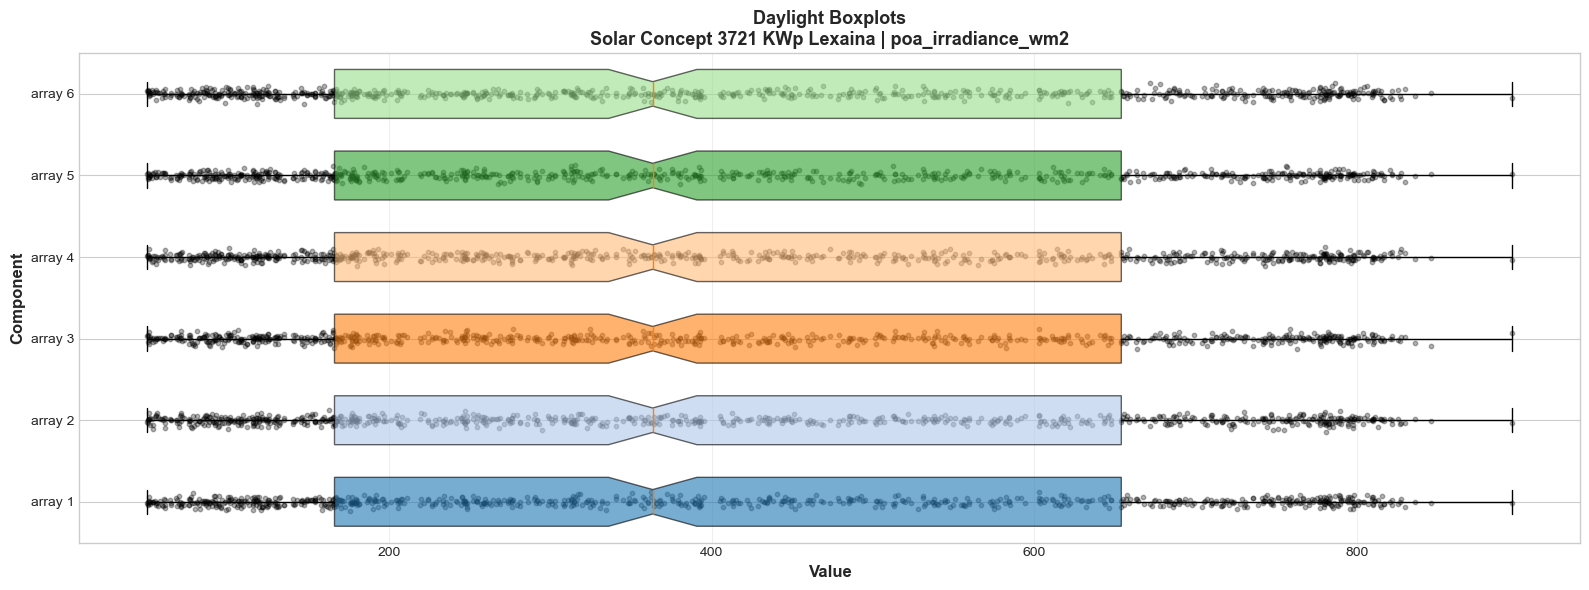

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


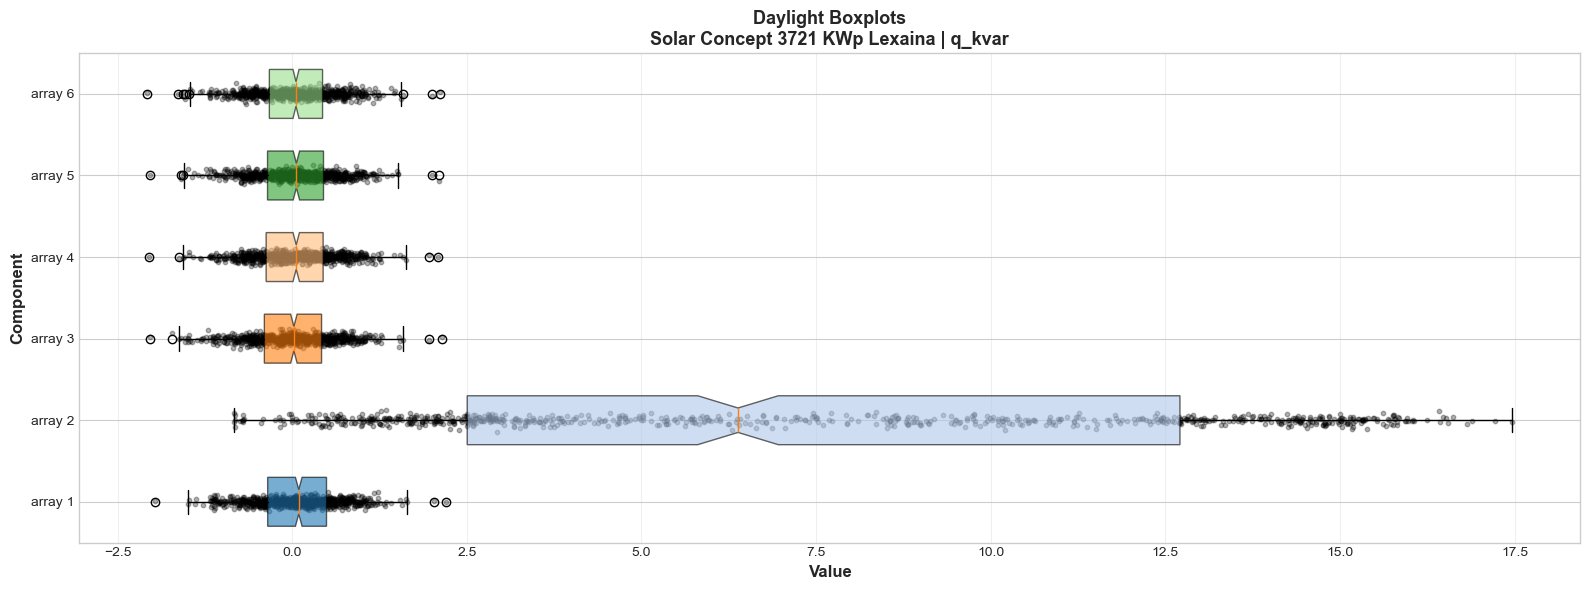

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


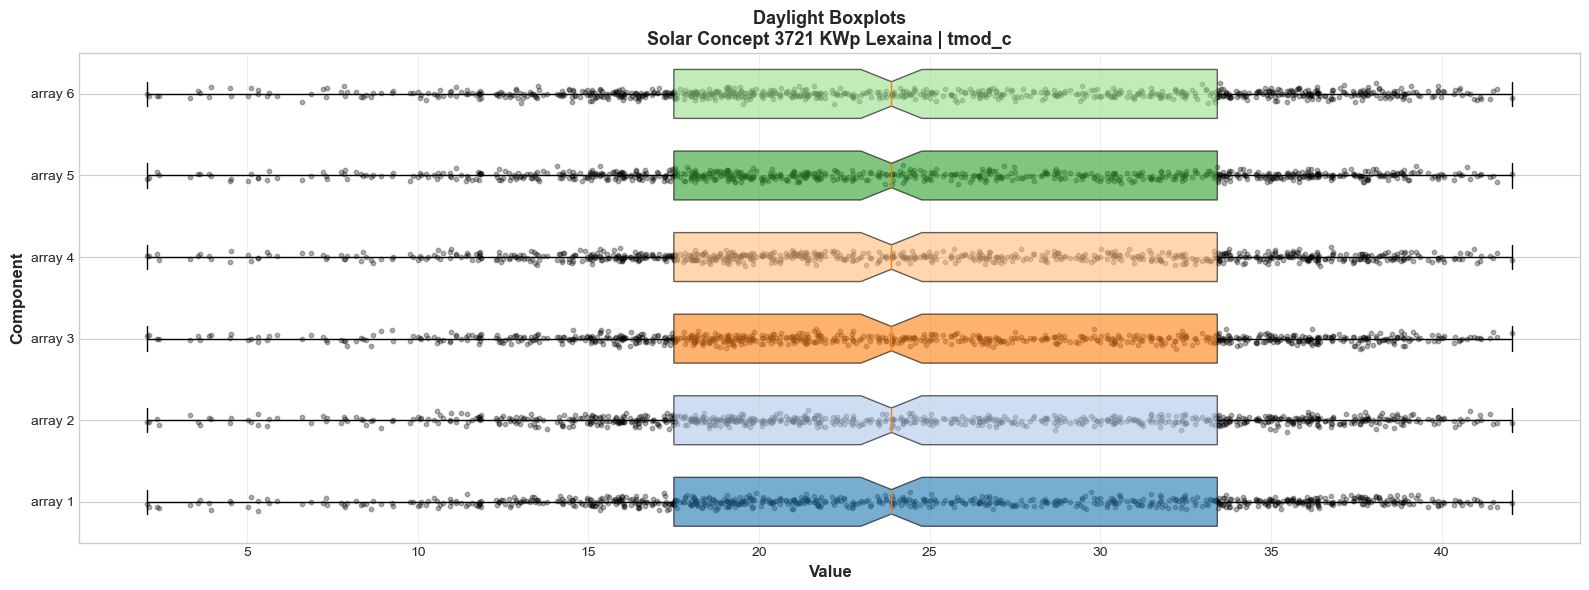

C:\Users\User\AppData\Local\Temp\ipykernel_15960\1713311424.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


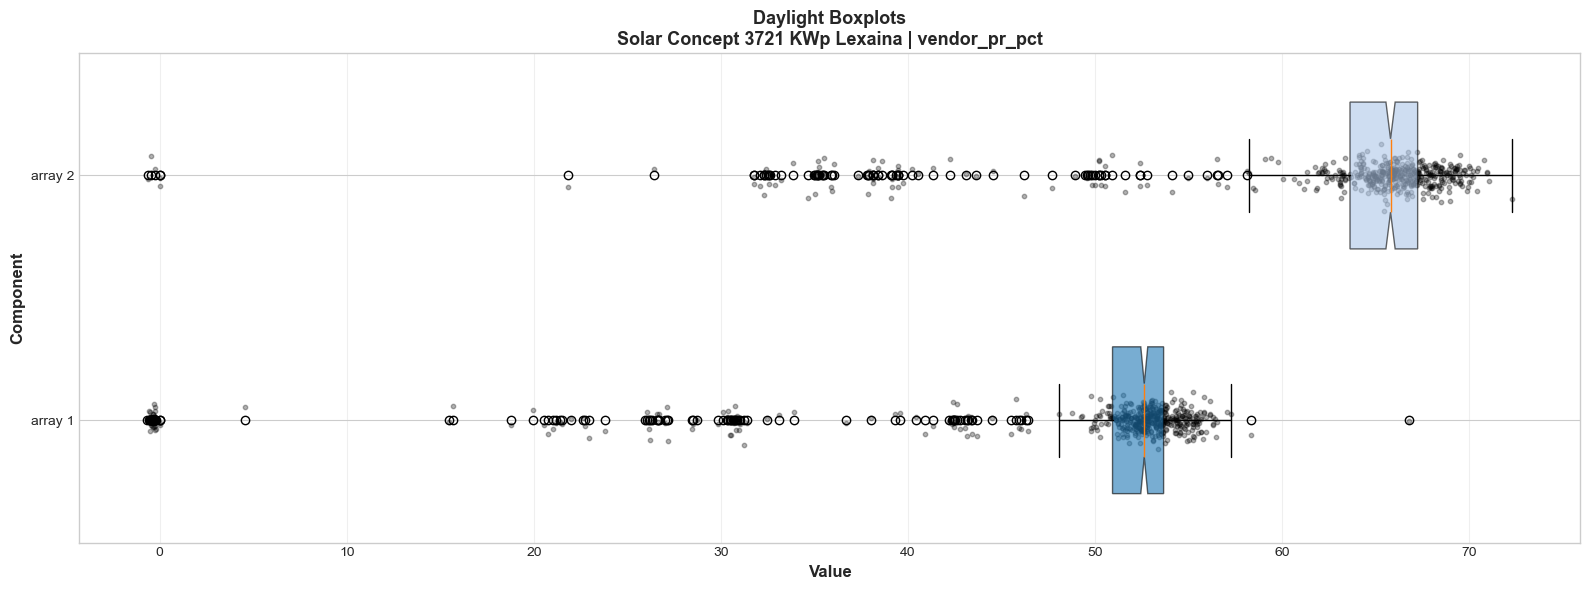

In [ ]:
def plot_boxplots_per_plant_signal_components_daylight(
    df,
    figsize=(16, 6),
    irradiance_signal="poa_irradiance_wm2",
    irradiance_threshold=50,
    plant_name=None,
    canonical_signal=None,
    component_type=None,
    component_id=None,
):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    required = {"plant_name", "canonical_signal", "value_rs", "component_type", "component_id"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # Apply filters (accept single value or list/tuple/set)
    def _apply_filter(data, col, val):
        if val is None:
            return data
        if isinstance(val, (list | tuple | set)):
            return data[data[col].isin(val)]
        return data[data[col] == val]

    df = _apply_filter(df, "plant_name", plant_name)
    df = _apply_filter(df, "canonical_signal", canonical_signal)
    df = _apply_filter(df, "component_type", component_type)
    df = _apply_filter(df, "component_id", component_id)

    # Ensure timestamp
    if "ts" in df.columns:
        df = df.copy()
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        ts_col = "ts"
    elif isinstance(df.index, pd.DatetimeIndex):
        ts_col = None
    else:
        raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")

    # Filter to daylight per plant based on irradiance signal
    daylight_rows = []
    for plant, plant_df in df.groupby("plant_name"):
        irr = plant_df[plant_df["canonical_signal"] == irradiance_signal]
        if irr.empty:
            print(f"No irradiance signal '{irradiance_signal}' for {plant}; skipping")
            continue

        if ts_col:
            daylight_ts = irr.loc[irr["value_rs"] >= irradiance_threshold, "ts"]
            is_daylight = plant_df["ts"].isin(daylight_ts)
        else:
            daylight_ts = irr.index[irr["value_rs"] >= irradiance_threshold]
            is_daylight = plant_df.index.isin(daylight_ts)

        daylight_rows.append(plant_df.loc[is_daylight])

    if not daylight_rows:
        print("No daylight data found.")
        return

    day_df = pd.concat(daylight_rows, axis=0)

    for (plant, signal), sig_df in day_df.groupby(["plant_name", "canonical_signal"]):
        data_by_component, labels = [], []
        for (ctype, cid), comp_df in sig_df.groupby(["component_type", "component_id"]):
            values = comp_df["value_rs"].dropna()
            if len(values) > 0:
                data_by_component.append(values)
                labels.append(f"{ctype} {cid}")

        if not data_by_component:
            continue

        fig, ax = plt.subplots(figsize=figsize)
        bp = ax.boxplot(
            data_by_component,
            vert=False,
            patch_artist=True,
            labels=labels,
            showfliers=True,
            notch=True,
            widths=0.6,
        )

        colors = plt.cm.tab20.colors
        for patch, color in zip(bp["boxes"], colors, strict=False):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        rng = np.random.default_rng(42)
        for i, values in enumerate(data_by_component, start=1):
            y_pos = rng.normal(i, 0.04, size=len(values))
            ax.scatter(values, y_pos, alpha=0.3, s=10, color="black")

        ax.set_xlabel("Value", fontsize=12, weight="bold")
        ax.set_ylabel("Component", fontsize=12, weight="bold")
        ax.set_title(
            f"Daylight Boxplots\n{plant} | {signal}",
            fontsize=13,
            weight="bold",
        )
        ax.grid(True, alpha=0.3, axis="x")

        plt.tight_layout()
        plt.show()


plot_boxplots_per_plant_signal_components_daylight(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    irradiance_signal="poa_irradiance_wm2",
    irradiance_threshold=50,
)

In [130]:
def plot_signal_vs_irradiance_by_component(
    df,
    plant_name,
    irradiance_signal="poa_irradiance_wm2",
    irradiance_threshold=50,
    component_type=None,
    max_points=20000,
):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    required = {"plant_name", "canonical_signal", "value_rs", "component_type", "component_id"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = df[df["plant_name"] == plant_name]
    if component_type is not None:
        df = df[df["component_type"] == component_type]

    if "ts" in df.columns:
        df = df.copy()
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        ts_col = "ts"
    elif isinstance(df.index, pd.DatetimeIndex):
        ts_col = None
    else:
        raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")

    irr = df[df["canonical_signal"] == irradiance_signal]
    if irr.empty:
        raise ValueError(f"Irradiance signal '{irradiance_signal}' not found for {plant_name}")

    if ts_col:
        daylight_ts = irr.loc[irr["value_rs"] >= irradiance_threshold, "ts"]
        df = df[df["ts"].isin(daylight_ts)]
        irr = irr.set_index("ts")["value_rs"]
    else:
        daylight_ts = irr.index[irr["value_rs"] >= irradiance_threshold]
        df = df[df.index.isin(daylight_ts)]
        irr = irr["value_rs"]

    if ts_col:
        df = df.join(irr.rename("irradiance"), on="ts")
    else:
        df = df.join(irr.rename("irradiance"))

    df = df.dropna(subset=["irradiance", "value_rs"])
    df = df[df["canonical_signal"] != irradiance_signal]

    if len(df) > max_points:
        df = df.sample(max_points, random_state=42)

    signals = sorted(df["canonical_signal"].unique())
    if not signals:
        print("No signals to plot.")
        return

    df["component_label"] = df["component_type"].astype(str) + " " + df["component_id"].astype(str)
    comps = sorted(df["component_label"].unique())
    palette = plt.cm.tab20.colors
    color_map = {c: palette[i % len(palette)] for i, c in enumerate(comps)}

    cols = 2
    rows = (len(signals) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
    axes = axes.flatten()

    for ax, sig in zip(axes, signals, strict=False):
        sub = df[df["canonical_signal"] == sig]

        corr_lines = []
        for comp, comp_df in sub.groupby("component_label"):
            ax.scatter(
                comp_df["irradiance"],
                comp_df["value_rs"],
                s=8,
                alpha=0.4,
                color=color_map[comp],
                label=comp,
            )

            # Trend line (linear fit)
            if len(comp_df) >= 3:
                x = comp_df["irradiance"].to_numpy()
                y = comp_df["value_rs"].to_numpy()
                coeffs = np.polyfit(x, y, 1)
                x_line = np.linspace(x.min(), x.max(), 50)
                y_line = coeffs[0] * x_line + coeffs[1]
                ax.plot(x_line, y_line, color=color_map[comp], linewidth=1.5, alpha=0.9)

                # Spearman correlation
                corr = comp_df["irradiance"].corr(comp_df["value_rs"], method="spearman")
                corr_lines.append(f"{comp}: ρ={corr:.2f}")

        ax.set_title(sig, fontsize=11, weight="bold")
        ax.set_ylabel("value_rs")
        ax.grid(True, alpha=0.2)

        # Correlation labels inside each subplot
        if corr_lines:
            ax.text(
                0.02,
                0.98,
                "\n".join(corr_lines),
                transform=ax.transAxes,
                va="top",
                ha="left",
                fontsize=8,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            )

    for ax in axes[len(signals) :]:
        ax.axis("off")

    axes[0].set_xlabel("Irradiance (W/m2)")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)

    fig.suptitle(f"{plant_name} — Signals vs Irradiance (Daylight)", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

c:\Users\User\miniconda3\envs\pv-fleet-health\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
c:\Users\User\miniconda3\envs\pv-fleet-health\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
c:\Users\User\miniconda3\envs\pv-fleet-health\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
c:\Users\User\miniconda3\envs\pv-fleet-health\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
c:\Users\User\miniconda3\envs\pv-fleet-health\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; th

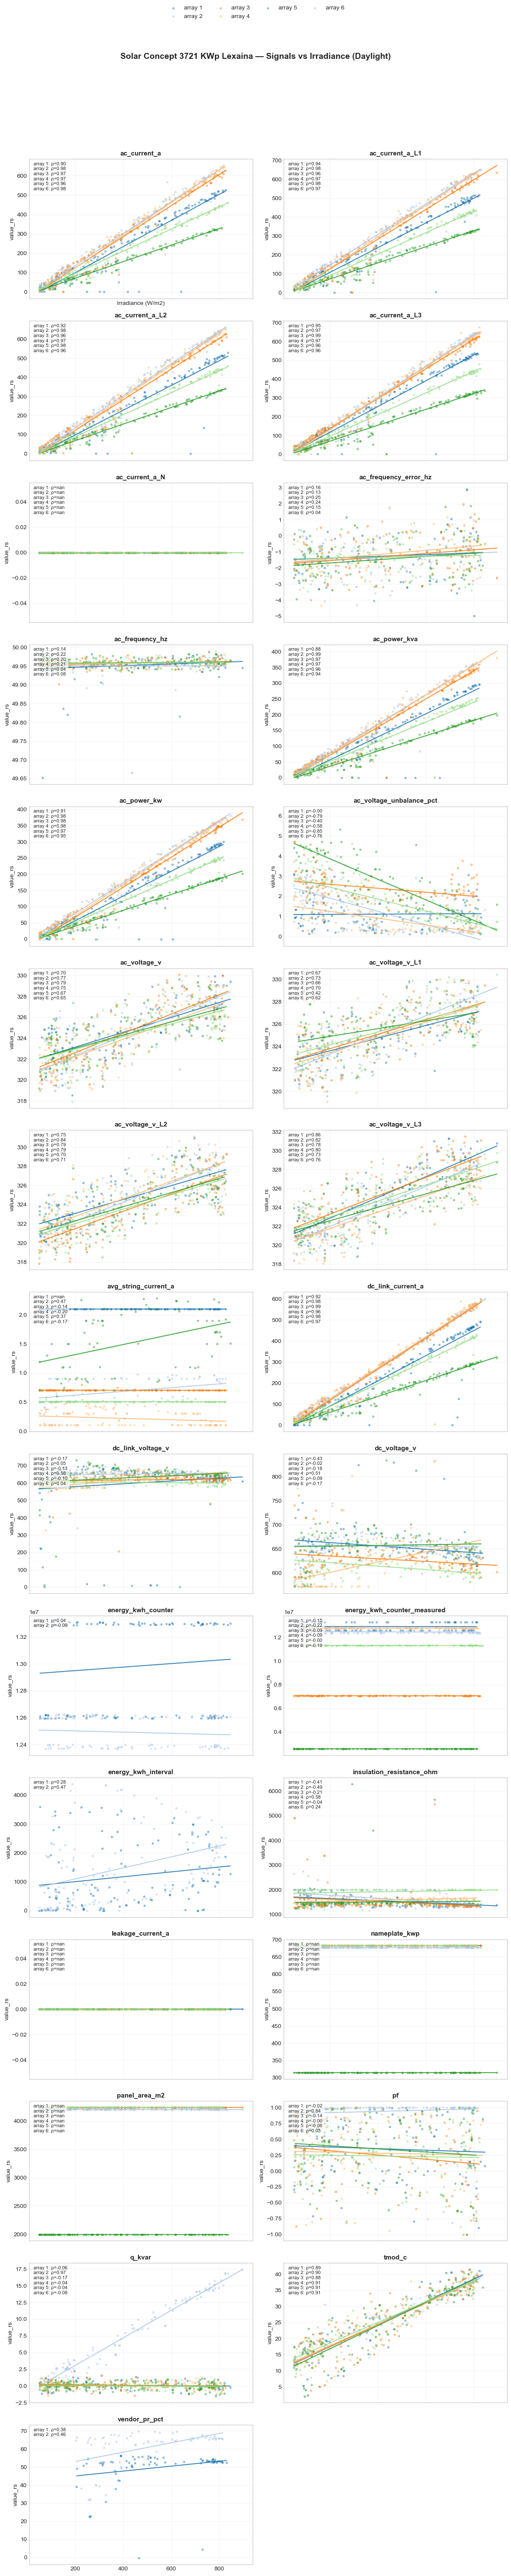

In [131]:
plot_signal_vs_irradiance_by_component(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    irradiance_signal="poa_irradiance_wm2",
    irradiance_threshold=50,
)

In [164]:
def plot_missingness_heatmap_daylight_components(
    df,
    plant_name,
    freq="D",
    irradiance_signal="poa_irradiance_wm2",
    irradiance_threshold=50,
    component_type=None,
    component_id=None,
    signals=None,
    cmap="cividis",
):
    import matplotlib.pyplot as plt
    import pandas as pd

    required = {"plant_name", "canonical_signal", "value_rs", "component_type", "component_id"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = df[df["plant_name"] == plant_name]
    if component_type is not None:
        df = df[df["component_type"] == component_type]
    if component_id is not None:
        df = df[df["component_id"] == component_id]
    if signals is not None:
        df = df[df["canonical_signal"].isin(signals)]

    if "ts" in df.columns:
        df = df.copy()
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        ts_col = "ts"
    elif isinstance(df.index, pd.DatetimeIndex):
        ts_col = None
    else:
        raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")

    irr = df[df["canonical_signal"] == irradiance_signal]
    if irr.empty:
        raise ValueError(f"Irradiance signal '{irradiance_signal}' not found for {plant_name}")

    if ts_col:
        daylight_ts = irr.loc[irr["value_rs"] >= irradiance_threshold, "ts"]
        df = df[df["ts"].isin(daylight_ts)]
        df = df.set_index("ts")
    else:
        daylight_ts = irr.index[irr["value_rs"] >= irradiance_threshold]
        df = df[df.index.isin(daylight_ts)]

    df["component_label"] = df["component_type"].astype(str) + " " + df["component_id"].astype(str)

    miss = (
        df.groupby(["component_label", "canonical_signal"])
        .resample(freq)["value_rs"]
        .apply(lambda s: s.isna().mean())
        .rename("missing_frac")
        .reset_index()
    )

    # Plot: one heatmap per component
    for comp, comp_df in miss.groupby("component_label"):
        pivot = comp_df.pivot(index="canonical_signal", columns="ts", values="missing_frac")

        plt.figure(figsize=(14, max(4, 0.35 * len(pivot))))
        sns.heatmap(
            pivot,
            cmap=cmap,
            vmin=0,
            vmax=1,
            cbar_kws={"label": "Missing fraction"},
        )
        plt.title(f"Daylight Missingness Heatmap — {plant_name} | {comp} ({freq})")
        plt.xlabel("Time")
        plt.ylabel("Signal")
        plt.tight_layout()
        plt.show()

    # Print summary statistics
    stats = (
        miss.groupby(["component_label", "canonical_signal"])["missing_frac"]
        .agg(count="count", mean="mean", median="median", min="min", max="max")
        .reset_index()
    )

    print("\nMissingness summary (daylight):")
    print(stats.sort_values(["component_label", "canonical_signal"]).to_string(index=False))

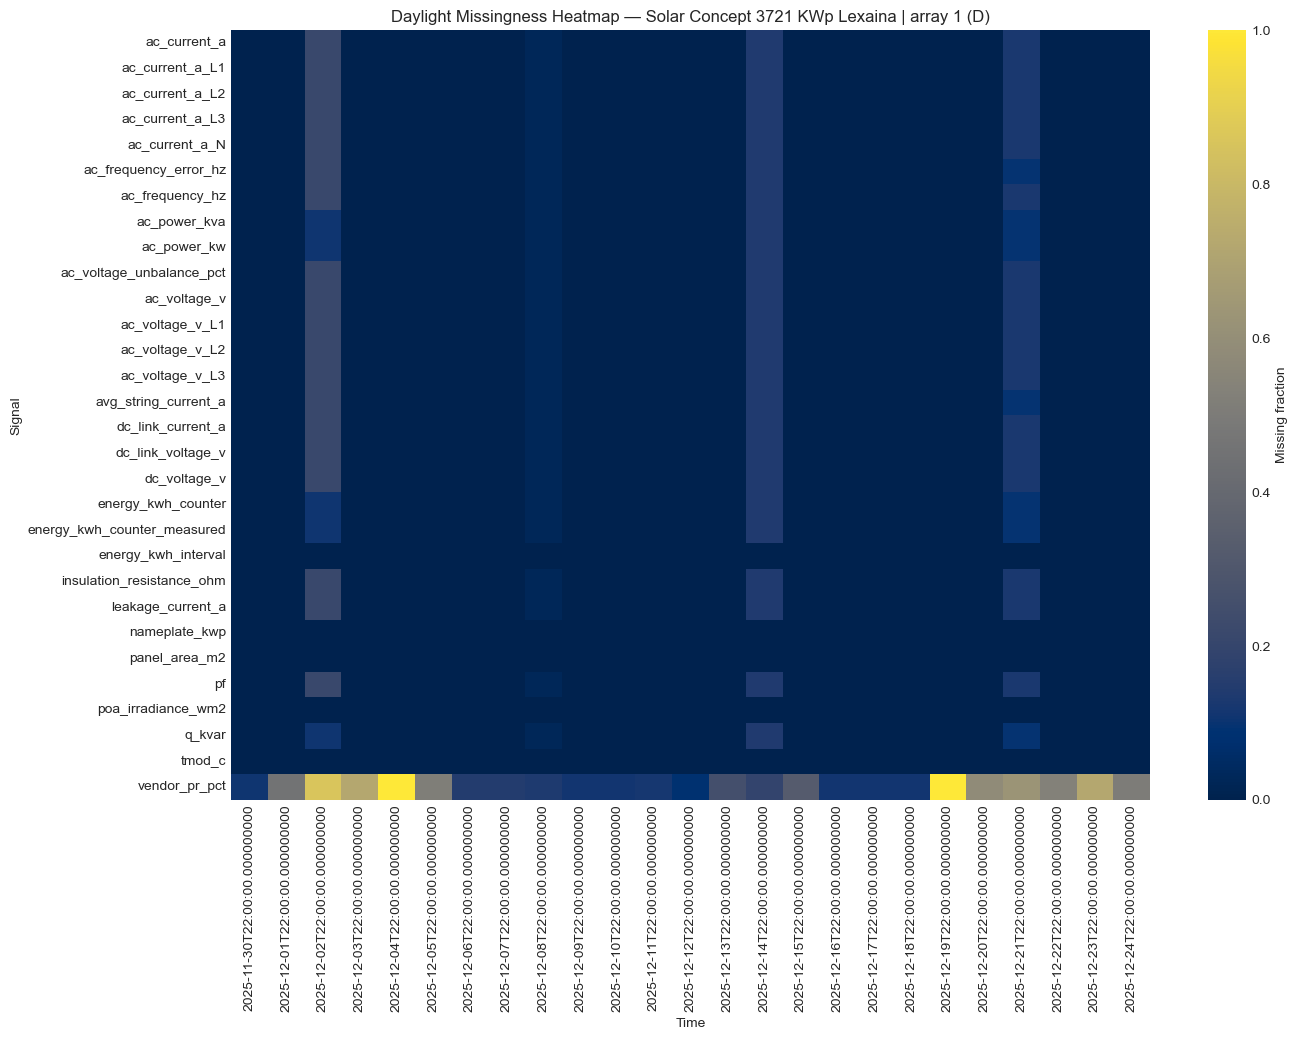

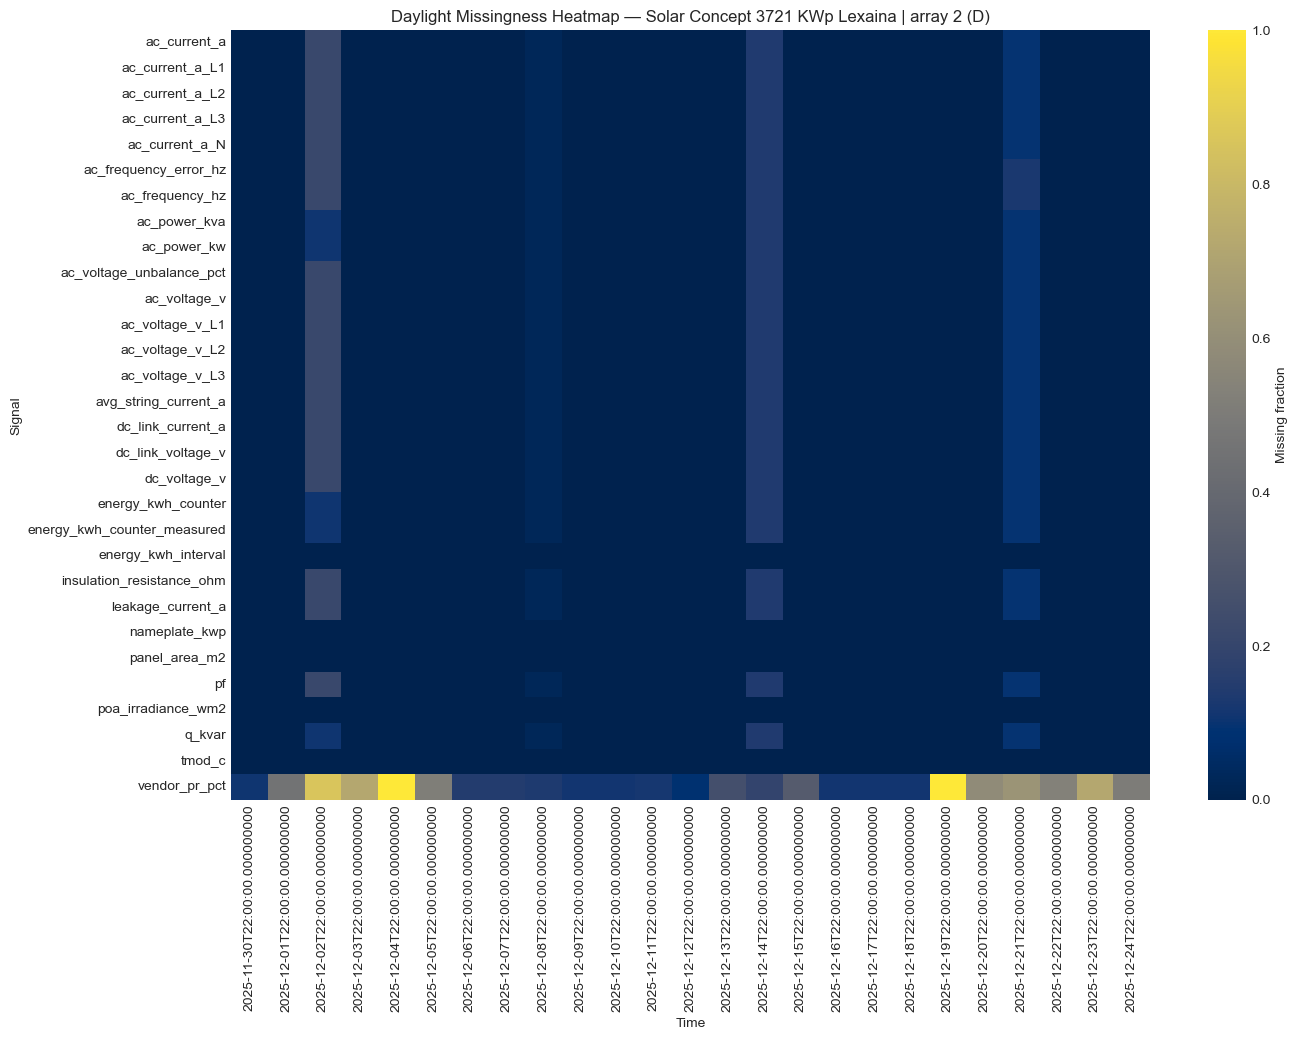

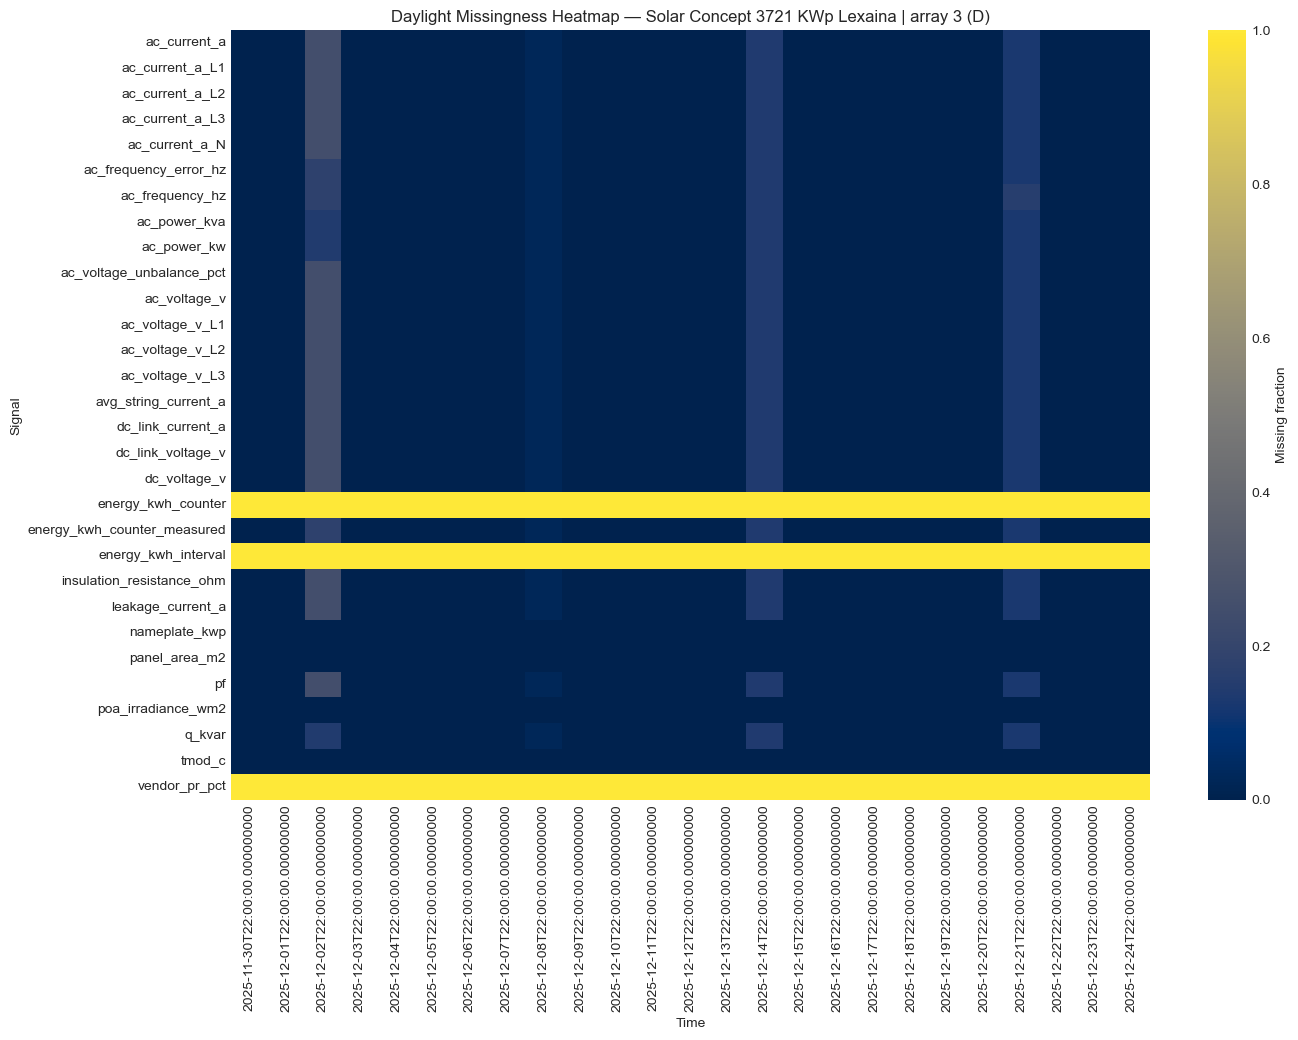

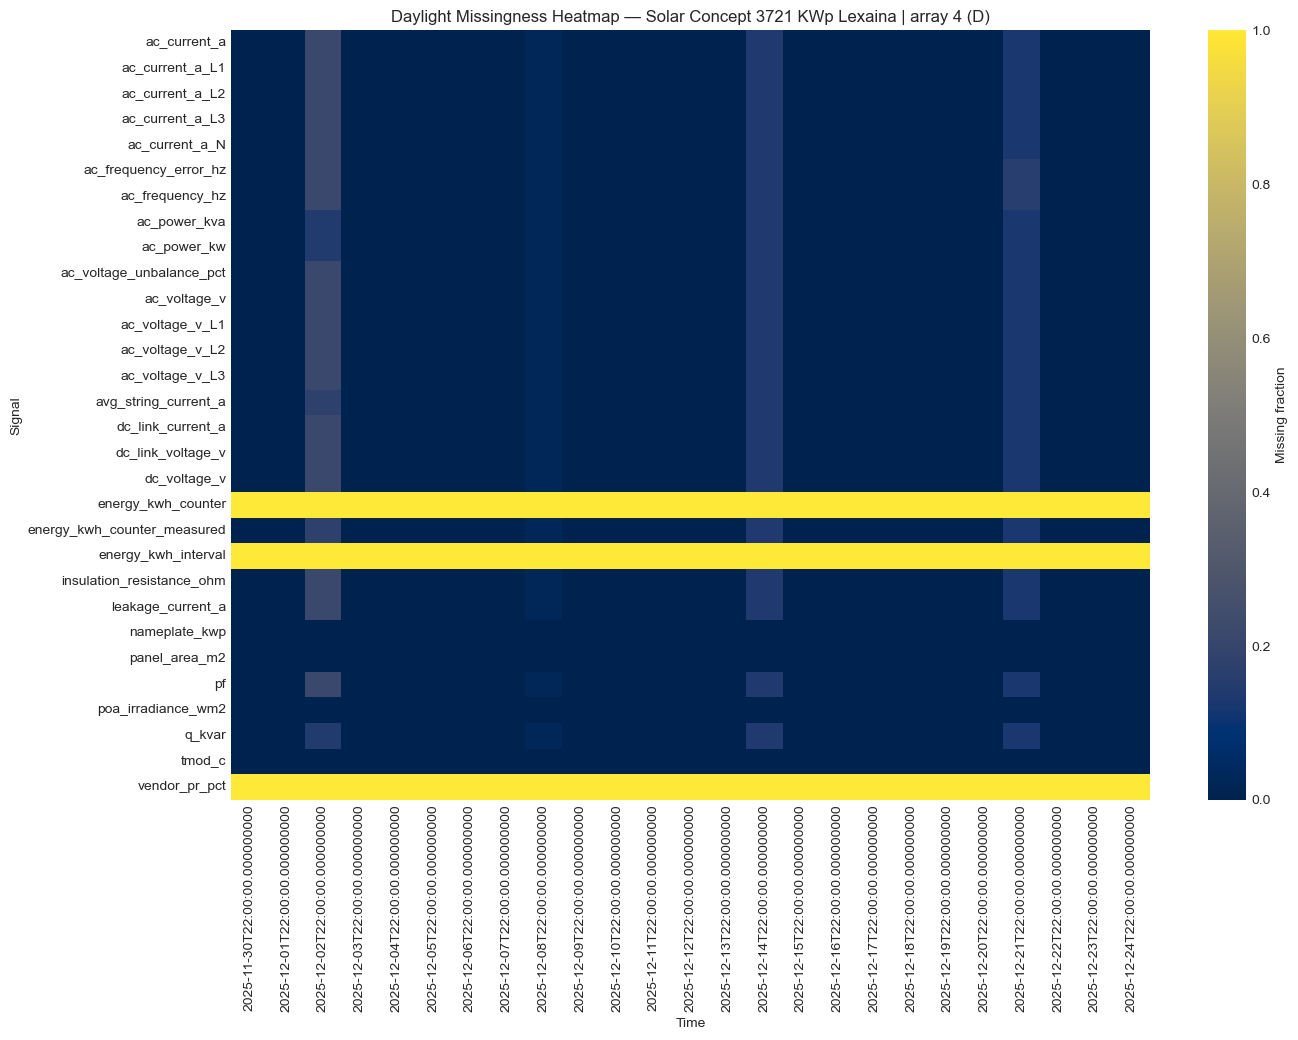

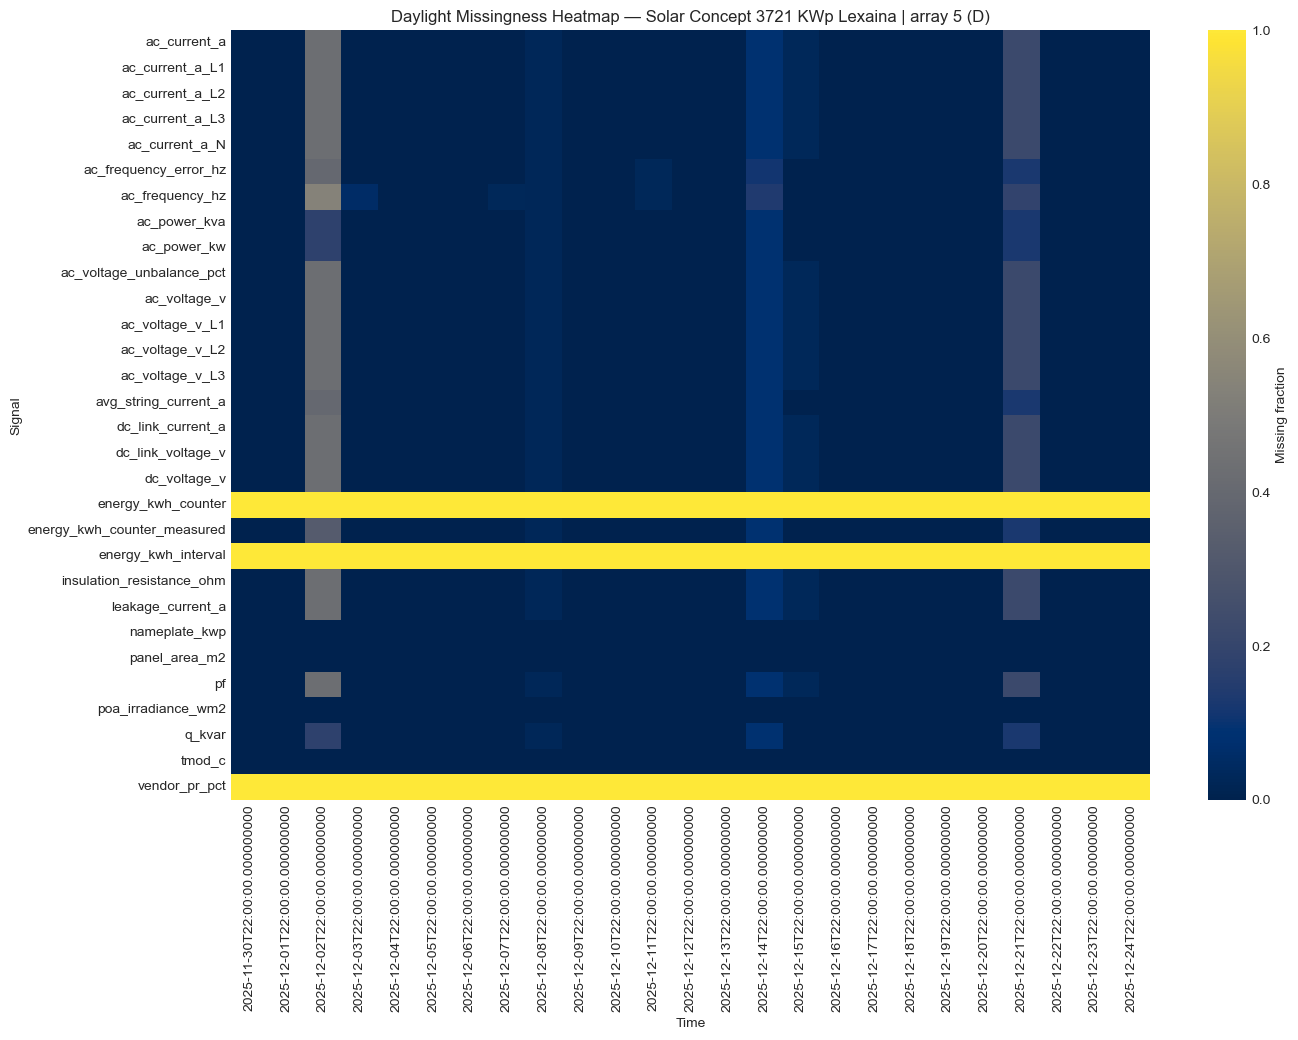

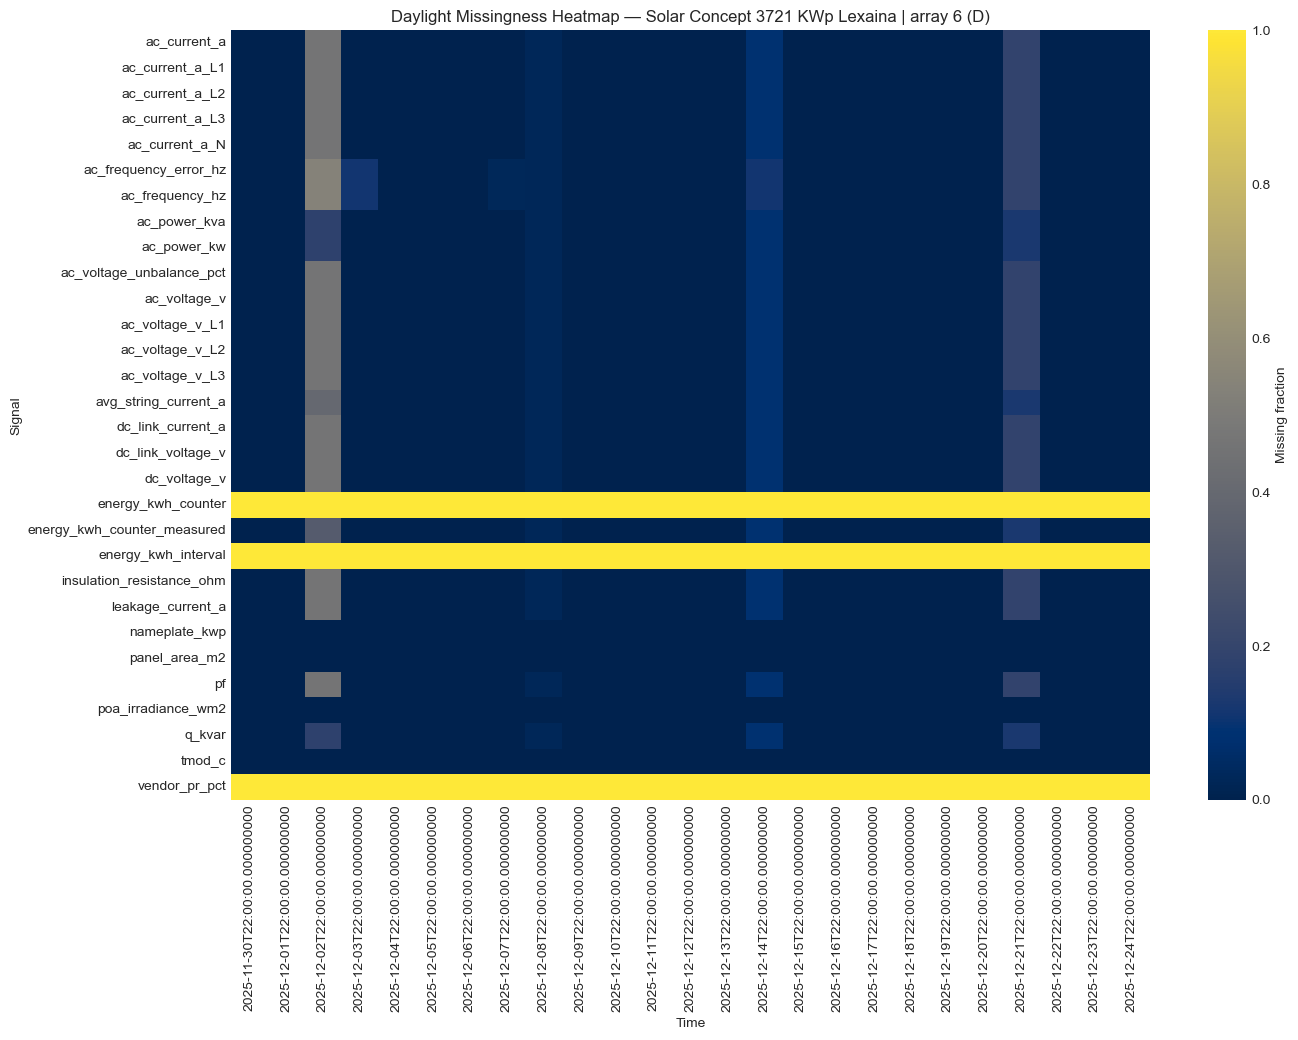


Missingness summary (daylight):
component_label            canonical_signal  count     mean   median      min      max
        array 1                ac_current_a     25 0.020208 0.000000 0.000000 0.214286
        array 1             ac_current_a_L1     25 0.020208 0.000000 0.000000 0.214286
        array 1             ac_current_a_L2     25 0.020208 0.000000 0.000000 0.214286
        array 1             ac_current_a_L3     25 0.020208 0.000000 0.000000 0.214286
        array 1              ac_current_a_N     25 0.020208 0.000000 0.000000 0.214286
        array 1       ac_frequency_error_hz     25 0.018958 0.000000 0.000000 0.214286
        array 1             ac_frequency_hz     25 0.020208 0.000000 0.000000 0.214286
        array 1                ac_power_kva     25 0.014672 0.000000 0.000000 0.138889
        array 1                 ac_power_kw     25 0.014672 0.000000 0.000000 0.138889
        array 1    ac_voltage_unbalance_pct     25 0.020208 0.000000 0.000000 0.214286
        ar

In [165]:
plot_missingness_heatmap_daylight_components(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    freq="D",
    component_type="array",  # optional
)

In [170]:
def dendrogram_heatmap_missingness_daylight(
    df,
    plant_name,
    freq="D",
    irradiance_signal="poa_irradiance_wm2",
    irradiance_threshold=50,
    component_type=None,
    signals=None,
    cmap="cividis",
    return_corr=True,
):
    import matplotlib.pyplot as plt
    import pandas as pd

    required = {"plant_name", "canonical_signal", "value_rs", "component_type", "component_id"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = df[df["plant_name"] == plant_name]
    if component_type is not None:
        df = df[df["component_type"] == component_type]
    if signals is not None:
        df = df[df["canonical_signal"].isin(signals)]

    if "ts" in df.columns:
        df = df.copy()
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        ts_col = "ts"
    elif isinstance(df.index, pd.DatetimeIndex):
        ts_col = None
    else:
        raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")

    irr = df[df["canonical_signal"] == irradiance_signal]
    if irr.empty:
        raise ValueError(f"Irradiance signal '{irradiance_signal}' not found for {plant_name}")

    if ts_col:
        daylight_ts = irr.loc[irr["value_rs"] >= irradiance_threshold, "ts"]
        df = df[df["ts"].isin(daylight_ts)].set_index("ts")
    else:
        daylight_ts = irr.index[irr["value_rs"] >= irradiance_threshold]
        df = df[df.index.isin(daylight_ts)]

    df["component_label"] = df["component_type"].astype(str) + " " + df["component_id"].astype(str)

    miss = (
        df.groupby(["component_label", "canonical_signal"])
        .resample(freq)["value_rs"]
        .apply(lambda s: s.isna().mean())
        .rename("missing_frac")
        .reset_index()
    )

    pivot = (
        miss.groupby(["component_label", "ts"])["missing_frac"].mean().unstack("component_label")
    )

    corr = pivot.corr()

    g = sns.clustermap(
        corr,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        linewidths=0.5,
        figsize=(8, 8),
        dendrogram_ratio=(0.15, 0.15),
        cbar_pos=(0.02, 0.8, 0.03, 0.18),
    )
    g.fig.suptitle(f"Dendrogram + Heatmap (Daylight Missingness)\n{plant_name}", y=1.02)
    plt.show()

    if return_corr:
        return corr

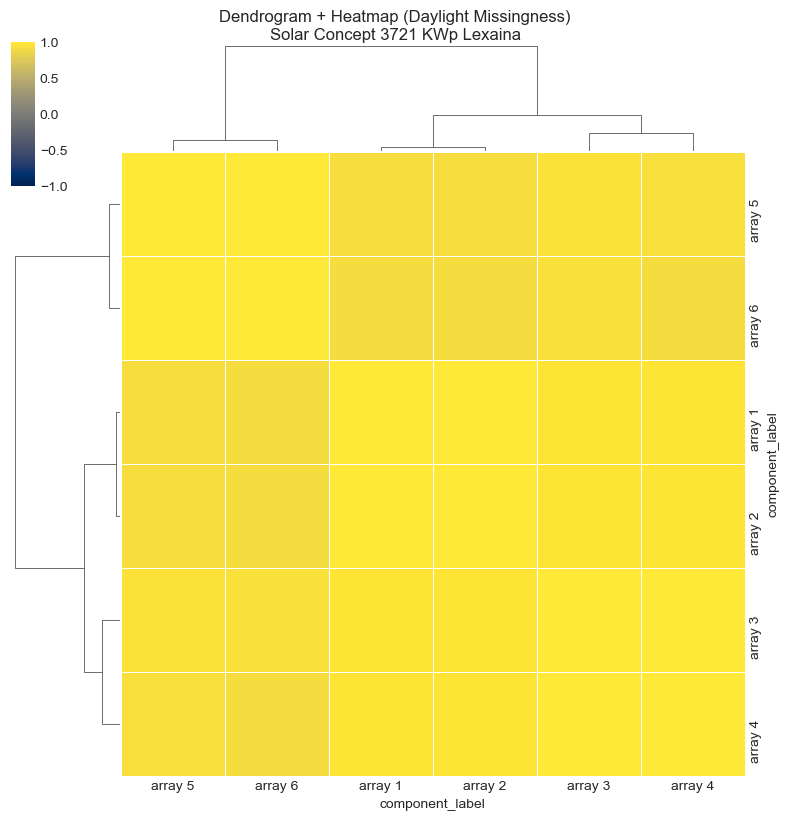

component_label   array 1   array 2   array 3   array 4   array 5   array 6
component_label                                                            
array 1          1.000000  0.997766  0.977061  0.976179  0.926745  0.918960
array 2          0.997766  1.000000  0.975420  0.971938  0.923303  0.919830
array 3          0.977061  0.975420  1.000000  0.997960  0.948866  0.941362
array 4          0.976179  0.971938  0.997960  1.000000  0.932364  0.921167
array 5          0.926745  0.923303  0.948866  0.932364  1.000000  0.996348
array 6          0.918960  0.919830  0.941362  0.921167  0.996348  1.000000

In [171]:
dendrogram_heatmap_missingness_daylight(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    freq="D",
)

In [ ]:
def plot_total_power_irradiance_tmod(
    df,
    power_signal="ac_power_kw",
    irradiance_signal="poa_irradiance_wm2",
    tmod_signal="tmod_c",
    freq=None,  # e.g., "15min" or "D"
    normalize=False,
    daily_power_agg="mean",  # "mean" or "sum"
):
    import matplotlib.pyplot as plt
    import pandas as pd

    required = {"plant_name", "canonical_signal", "value_rs"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    if "ts" in df.columns:
        df = df.copy()
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df = df.set_index("ts")
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")

    target_signals = [power_signal, irradiance_signal, tmod_signal]
    df = df[df["canonical_signal"].isin(target_signals)]

    def _normalize(s):
        s = s.dropna()
        if s.empty or s.max() == s.min():
            return s * 0
        return (s - s.min()) / (s.max() - s.min())

    if daily_power_agg not in {"mean", "sum"}:
        raise ValueError("daily_power_agg must be 'mean' or 'sum'")

    for plant, g in df.groupby("plant_name"):
        power = g[g["canonical_signal"] == power_signal].groupby(level=0)["value_rs"].sum()
        irr = g[g["canonical_signal"] == irradiance_signal].groupby(level=0)["value_rs"].mean()
        tmod = g[g["canonical_signal"] == tmod_signal].groupby(level=0)["value_rs"].mean()

        if freq:
            power = power.resample(freq).sum()
            irr = irr.resample(freq).mean()
            tmod = tmod.resample(freq).mean()

        daily_power = getattr(power.resample("D"), daily_power_agg)()

        fig, (ax1, ax2) = plt.subplots(
            2,
            1,
            figsize=(14, 6),
            sharex=True,
            gridspec_kw={"height_ratios": [3, 1]},
        )

        if normalize:
            power = _normalize(power)
            irr = _normalize(irr)
            tmod = _normalize(tmod)
            daily_power = _normalize(daily_power)

            ax1.plot(power.index, power, color="#1f77b4", label="Power (normalized)")
            ax1.plot(irr.index, irr, color="#ff7f0e", label="Irradiance (normalized)")
            ax1.plot(tmod.index, tmod, color="#2ca02c", label="Tmod (normalized)")
            ax1.set_ylabel("Normalized (0–1)")
            ax1.legend(loc="upper left", frameon=False)
        else:
            ax1.plot(power.index, power, color="#1f77b4", label="Total AC Power (kW)")
            ax1.set_ylabel("Total AC Power (kW)", color="#1f77b4")
            ax1.tick_params(axis="y", labelcolor="#1f77b4")

            ax1b = ax1.twinx()
            ax1b.plot(irr.index, irr, color="#ff7f0e", label="Irradiance (W/m2)")
            ax1b.set_ylabel("Irradiance (W/m2)", color="#ff7f0e")
            ax1b.tick_params(axis="y", labelcolor="#ff7f0e")

            ax1c = ax1.twinx()
            ax1c.spines["right"].set_position(("axes", 1.1))
            ax1c.plot(tmod.index, tmod, color="#2ca02c", label="Tmod (C)")
            ax1c.set_ylabel("Tmod (C)", color="#2ca02c")
            ax1c.tick_params(axis="y", labelcolor="#2ca02c")

            lines = ax1.get_lines() + ax1b.get_lines() + ax1c.get_lines()
            labels = [_l.get_label() for _l in lines]
            ax1.legend(lines, labels, loc="upper left", frameon=False)

        ax2.step(
            daily_power.index,
            daily_power,
            where="post",
            color="#1f77b4",
            linewidth=1.5,
        )
        ax2.set_ylabel(f"Daily {daily_power_agg}\nPower" + (" (norm)" if normalize else ""))
        ax2.grid(True, alpha=0.3)

        ax1.set_title(
            f"{plant} — Total Power vs Irradiance vs Tmod" + (" (normalized)" if normalize else ""),
            fontsize=13,
            weight="bold",
        )
        ax2.set_xlabel("Time")
        ax1.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

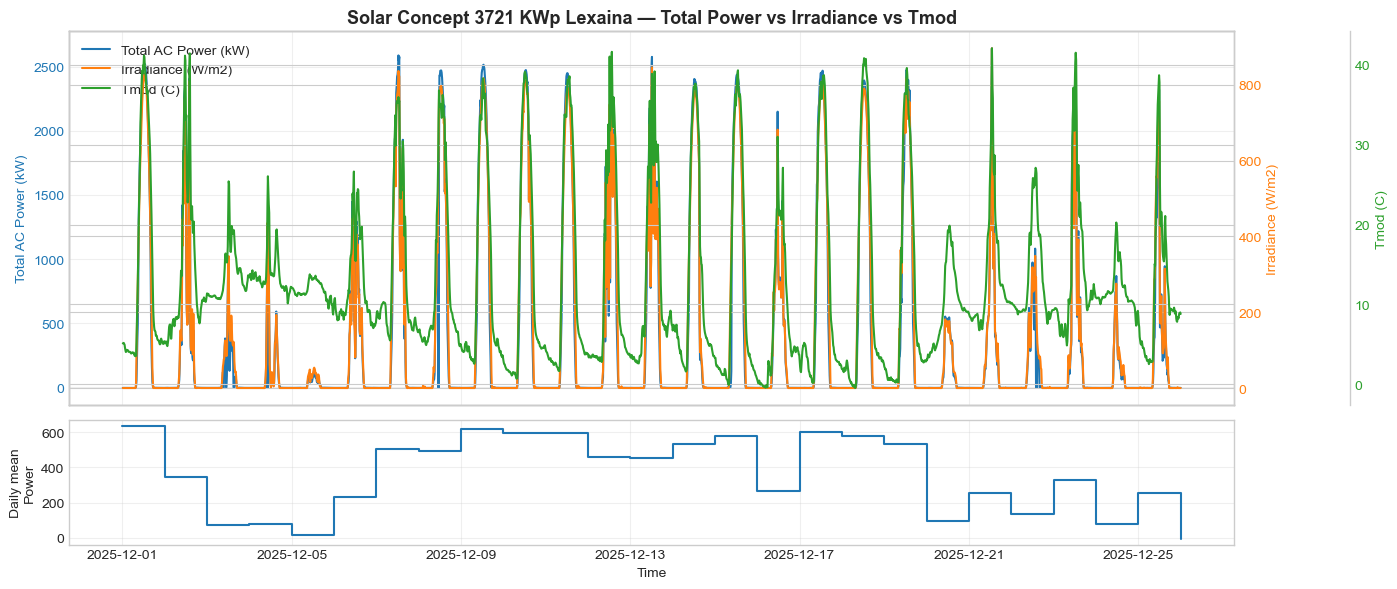

In [215]:
plot_total_power_irradiance_tmod(scada_rs, normalize=False, daily_power_agg="mean")

In [200]:
def plot_power_irradiance_corr_heatmap(
    df,
    power_signal="ac_power_kw",
    irradiance_signal="poa_irradiance_wm2",
    freq="D",
    window=7,
    cmap="cividis",
    max_xticks=10,
):
    import matplotlib.pyplot as plt
    import pandas as pd

    required = {"plant_name", "canonical_signal", "value_rs"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    if "ts" in df.columns:
        df = df.copy()
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df = df.set_index("ts")
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")

    df = df[df["canonical_signal"].isin([power_signal, irradiance_signal])]

    corr_frames = []
    for plant, g in df.groupby("plant_name"):
        power = g[g["canonical_signal"] == power_signal].groupby(level=0)["value_rs"].sum()
        irr = g[g["canonical_signal"] == irradiance_signal].groupby(level=0)["value_rs"].mean()

        if freq:
            power = power.resample(freq).sum()
            irr = irr.resample(freq).mean()

        aligned = pd.concat([power.rename("power"), irr.rename("irr")], axis=1).dropna()
        if aligned.empty:
            continue

        rolling_corr = aligned["power"].rolling(window).corr(aligned["irr"])
        corr_frames.append(rolling_corr.rename(plant))

    if not corr_frames:
        print("No correlation data to plot.")
        return

    corr_df = pd.concat(corr_frames, axis=1).T  # plants x time

    plt.figure(figsize=(14, max(4, 0.4 * len(corr_df))))
    ax = sns.heatmap(
        corr_df,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        cbar_kws={"label": f"Rolling corr (window={window})"},
    )
    plt.title("Rolling Correlation: Total AC Power vs Irradiance")
    plt.xlabel("Time")
    plt.ylabel("Plant")

    # Reduce and rotate x tick labels (safe)
    labels = corr_df.columns
    n = len(labels)

    if n > max_xticks:
        step = max(1, n // max_xticks)
        idx = list(range(0, n, step))
    else:
        idx = list(range(n))

    ax.set_xticks(idx)
    ax.set_xticklabels(labels[idx].strftime("%Y-%m-%d"), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

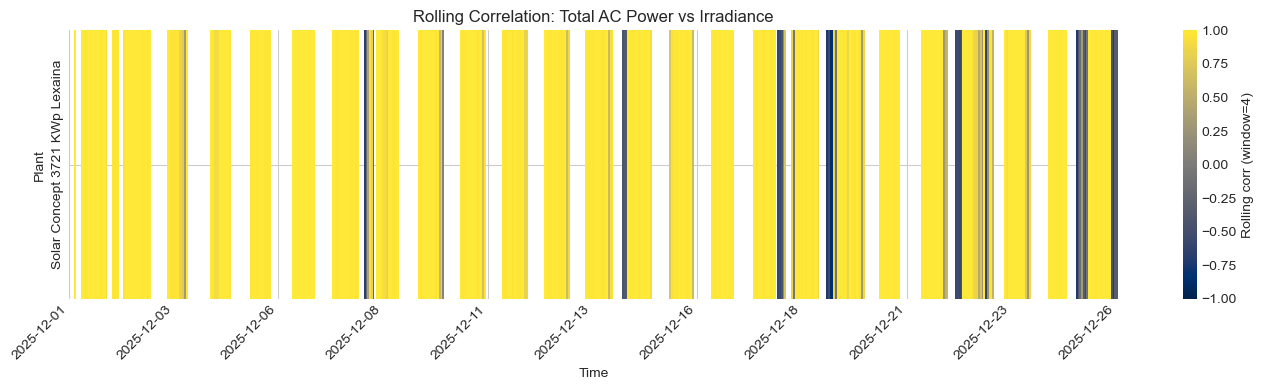

In [207]:
plot_power_irradiance_corr_heatmap(
    scada_rs,
    freq="h",
    window=4,
)

In [262]:
import numpy as np
import pandas as pd


def quality_guardrails_clearsky(
    df,
    plant_coords,
    tz_map=None,
    irr_signal="poa_irradiance_wm2",
    power_signal="ac_power_kw",
    tmod_signal="tmod_c",
    temp_bounds=(-40.0, 85.0),
    power_night_threshold_kw=0.05,
    irr_night_threshold_wm2=5.0,
    flatline_window=6,
    flatline_tol=1e-6,
    mad_k=5.0,
    step_change_sigma=6.0,
    compare_to_clearsky=True,
    clearsky_exceed_factor=1.5,
    daylight_irr_threshold=50.0,  # NEW: daylight threshold for QA checks
):
    """
    Returns (qa_flags, qa_summary).
    - plant_coords: dict {plant_name: (lat, lon)} or {'_default': (lat, lon)}
    - tz_map: optional dict {plant_name: 'Europe/Madrid'} or {'_default': 'UTC'}
    - daylight_irr_threshold: minimum irradiance to consider "daylight" for flatline/step-change checks
    """
    try:
        import pvlib
    except Exception as e:
        raise ImportError(
            "pvlib is required for clearsky QA. Install via `pip install pvlib`."
        ) from e

    # Normalize: ensure ts column exists and is datetime
    data = df.copy()
    if "ts" not in data.columns:
        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index().rename(columns={"index": "ts"})
        else:
            raise ValueError("DataFrame must have a 'ts' column or a DatetimeIndex")
    data["ts"] = pd.to_datetime(data["ts"], errors="coerce")
    data = data.dropna(subset=["ts"]).sort_values("ts")

    if tz_map is None:
        tz_map = {"_default": "UTC"}

    issues = []

    # Iterate per plant for solar position + clearsky
    for plant, gplant in data.groupby("plant_name"):
        # Build unique time index for this plant (aggregate across components/signals)
        unique_times = pd.DatetimeIndex(gplant["ts"].unique()).sort_values()

        lat_lon = plant_coords.get(plant, plant_coords.get("_default"))
        tz = tz_map.get(plant, tz_map.get("_default", "UTC"))

        if lat_lon is None:
            # Fallback: simple hour-based night detection
            times_local = (
                unique_times.tz_localize(tz, ambiguous="infer")
                if unique_times.tz is None
                else unique_times.tz_convert(tz)
            )
            local_hour = times_local.hour
            night_lookup = pd.Series(
                (local_hour <= 5) | (local_hour >= 20), index=unique_times
            ).rename("night")
            cs_ghi_lookup = pd.Series(np.nan, index=unique_times, dtype="float64").rename("cs_ghi")
        else:
            lat, lon = lat_lon
            loc = pvlib.location.Location(latitude=lat, longitude=lon, tz=tz)
            times_local = (
                unique_times.tz_localize(tz, ambiguous="infer")
                if unique_times.tz is None
                else unique_times.tz_convert(tz)
            )
            solpos = loc.get_solarposition(times_local)
            night_lookup = (solpos["apparent_elevation"] <= 0).rename("night")
            night_lookup.index = unique_times  # align to naive times
            if compare_to_clearsky:
                cs = loc.get_clearsky(times_local, model="ineichen")
                cs_ghi_lookup = cs["ghi"].rename("cs_ghi")
                cs_ghi_lookup.index = unique_times
            else:
                cs_ghi_lookup = pd.Series(np.nan, index=unique_times, dtype="float64").rename(
                    "cs_ghi"
                )

        # Join night/clearsky onto plant data via ts
        gplant = gplant.merge(
            night_lookup.reset_index().rename(columns={"index": "ts"}), on="ts", how="left"
        )
        if compare_to_clearsky:
            gplant = gplant.merge(
                cs_ghi_lookup.reset_index().rename(columns={"index": "ts"}), on="ts", how="left"
            )

        # Get plant-level irradiance for daylight filtering
        plant_irr = (
            gplant[gplant["canonical_signal"] == irr_signal].groupby("ts")["value_rs"].mean()
        )
        daylight_ts = plant_irr[plant_irr >= daylight_irr_threshold].index

        # Per component + signal QA
        for (ctype, cid, sig), gsig in gplant.groupby(
            ["component_type", "component_id", "canonical_signal"]
        ):
            s = gsig.set_index("ts")["value_rs"].astype(float).sort_index()
            night = gsig.set_index("ts")["night"].astype(bool).sort_index()
            cs_ghi = gsig.set_index("ts").get("cs_ghi", pd.Series(index=s.index, dtype="float64"))

            # Daylight mask for this component
            is_daylight = s.index.isin(daylight_ts)

            # Basic sanity flags (run on all data)
            if sig == irr_signal:
                neg_mask = s < 0
                for ts, val in s[neg_mask].items():
                    issues.append((ts, plant, ctype, cid, sig, "irr_negative", float(val)))

                irr_night = night & (s > irr_night_threshold_wm2)
                for ts, val in s[irr_night].items():
                    issues.append((ts, plant, ctype, cid, sig, "irr_at_night", float(val)))

                # NEW: Only check clearsky during daylight AND when clearsky data exists
                if compare_to_clearsky and not cs_ghi.isna().all():
                    # Exclude night from clearsky comparison
                    exceed = (~night) & (s > clearsky_exceed_factor * cs_ghi.fillna(np.inf))
                    for ts, val in s[exceed].items():
                        issues.append(
                            (ts, plant, ctype, cid, sig, "irr_exceeds_clearsky", float(val))
                        )

            if sig == power_signal:
                p_night = night & (s > power_night_threshold_kw)
                for ts, val in s[p_night].items():
                    issues.append((ts, plant, ctype, cid, sig, "power_at_night", float(val)))

            if sig == tmod_signal:
                bad_temp = (s < temp_bounds[0]) | (s > temp_bounds[1])
                for ts, val in s[bad_temp].items():
                    issues.append((ts, plant, ctype, cid, sig, "temp_out_of_bounds", float(val)))

            # NEW: Daylight-only checks for flatline, step-change, MAD outliers
            s_day = s[is_daylight]

            if len(s_day) < flatline_window:
                continue  # Not enough daylight data for these checks

            # Flat-line detection (daylight only)
            if flatline_window and flatline_window > 1:
                rolling_std = s_day.rolling(flatline_window, min_periods=flatline_window).std()
                flatline = rolling_std.fillna(np.inf) <= flatline_tol
                for ts, val in s_day[flatline].items():
                    issues.append((ts, plant, ctype, cid, sig, "flatline", float(val)))

            # Step-change detection via MAD of diffs (daylight only)
            diffs = s_day.diff().dropna()
            if len(diffs) > 10:
                mad_diff = np.median(np.abs(diffs - np.median(diffs))) * 1.4826
                p99 = np.percentile(np.abs(diffs), 99)
                threshold = max(mad_diff * step_change_sigma, p99 * 1.5)

                if threshold > 0:
                    step_mask = np.abs(diffs) > threshold
                    for ts, _ in diffs[step_mask].items():
                        # Use the actual signal value at the flagged timestamp
                        issues.append(
                            (
                                ts,
                                plant,
                                ctype,
                                cid,
                                sig,
                                "step_change_outlier",
                                float(s_day.loc[ts]),
                            )
                        )

            # Per-sensor outlier via MAD around median (daylight only)
            if len(s_day) > 10:
                med = np.median(s_day)
                mad = np.median(np.abs(s_day - med)) * 1.4826
                if np.isfinite(med) and mad > 0:
                    outlier_mask = np.abs(s_day - med) > (mad_k * mad)
                    for ts, val in s_day[outlier_mask].items():
                        issues.append((ts, plant, ctype, cid, sig, "mad_outlier", float(val)))

    if not issues:
        qa_flags = pd.DataFrame(
            columns=[
                "ts",
                "plant_name",
                "component_type",
                "component_id",
                "canonical_signal",
                "issue",
                "value",
            ]
        )
    else:
        qa_flags = pd.DataFrame(
            issues,
            columns=[
                "ts",
                "plant_name",
                "component_type",
                "component_id",
                "canonical_signal",
                "issue",
                "value",
            ],
        ).sort_values("ts")

    qa_summary = (
        qa_flags.groupby(
            ["plant_name", "component_type", "component_id", "canonical_signal", "issue"]
        )
        .size()
        .rename("count")
        .reset_index()
        .sort_values(["plant_name", "component_type", "component_id", "canonical_signal", "issue"])
    )
    return qa_flags, qa_summary

In [267]:
# Minimal coords/tz — use real ones for best results
plant_coords = {
    "_default": (38.0, -1.5)  # lat, lon
}
tz_map = {"_default": "Europe/Madrid"}

qa_flags, qa_summary = quality_guardrails_clearsky(
    scada_rs,
    plant_coords=plant_coords,
    tz_map=tz_map,
    irr_signal="poa_irradiance_wm2",
    power_signal="ac_power_kw",
    tmod_signal="tmod_c",
    temp_bounds=(-40, 85),
    power_night_threshold_kw=10,
    irr_night_threshold_wm2=10,
    flatline_window=10,
    flatline_tol=1e-6,
    mad_k=5.0,  # Back to standard threshold
    step_change_sigma=6.0,  # Back to standard threshold
    compare_to_clearsky=True,
    clearsky_exceed_factor=1.5,
    daylight_irr_threshold=50.0,  # NEW: only run advanced checks during daylight
)

print("QA flags:", len(qa_flags))
display(qa_summary.head(20))

# Save outputs
save_parquet(qa_flags, str(paths.stage_dir / "qa_flags.parquet"))
save_parquet(qa_summary, str(paths.stage_dir / "qa_summary.parquet"))

QA flags: 28675


plant_name component_type component_id  \
0   Solar Concept 3721 KWp Lexaina          array            1   
1   Solar Concept 3721 KWp Lexaina          array            1   
2   Solar Concept 3721 KWp Lexaina          array            1   
3   Solar Concept 3721 KWp Lexaina          array            1   
4   Solar Concept 3721 KWp Lexaina          array            1   
5   Solar Concept 3721 KWp Lexaina          array            1   
6   Solar Concept 3721 KWp Lexaina          array            1   
7   Solar Concept 3721 KWp Lexaina          array            1   
8   Solar Concept 3721 KWp Lexaina          array            1   
9   Solar Concept 3721 KWp Lexaina          array            1   
10  Solar Concept 3721 KWp Lexaina          array            1   
11  Solar Concept 3721 KWp Lexaina          array            1   
12  Solar Concept 3721 KWp Lexaina          array            1   
13  Solar Concept 3721 KWp Lexaina          array            1   
14  Solar Concept 3721 KWp Lexaina          array            1   
15  Solar Concept 3721 KWp Lexaina          array            1   
16  Solar Concept 3721 KWp Lexaina          array            1   
17  Solar Concept 3721 KWp Lexaina          array            1   
18  Solar Concept 3721 KWp Lexaina          array            1   
19  Solar Concept 3721 KWp Lexaina          array            2   

             canonical_signal                 issue  count  
0                ac_current_a              flatline      7  
1             ac_current_a_L3              flatline      8  
2              ac_current_a_N              flatline    709  
3             ac_frequency_hz   step_change_outlier      7  
4                 ac_power_kw        power_at_night     53  
5    ac_voltage_unbalance_pct   step_change_outlier      1  
6             ac_voltage_v_L2   step_change_outlier      1  
7        avg_string_current_a              flatline    710  
8           dc_link_current_a              flatline      8  
9           dc_link_voltage_v              flatline      7  
10  insulation_resistance_ohm              flatline      8  
11  insulation_resistance_ohm   step_change_outlier      7  
12          leakage_current_a              flatline    709  
13              nameplate_kwp              flatline    773  
14              panel_area_m2              flatline    773  
15                         pf              flatline      8  
16         poa_irradiance_wm2          irr_at_night    113  
17         poa_irradiance_wm2  irr_exceeds_clearsky    309  
18         poa_irradiance_wm2   step_change_outlier      1  
19             ac_current_a_N              flatline    710

In [268]:
# Issue breakdown by type
issue_counts = qa_summary.groupby("issue")["count"].sum().sort_values(ascending=False)
print("\nTotal flags by issue type:")
display(issue_counts)

# Most problematic components
top_problems = (
    qa_summary.groupby(["plant_name", "component_type", "component_id"])["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 most flagged components:")
display(top_problems)

# Sample flagged timestamps
print("\nSample flagged events (first 20):")
display(qa_flags.head(20))


Total flags by issue type:


issue
flatline                24284
irr_exceeds_clearsky     2781
irr_at_night             1017
power_at_night            500
step_change_outlier        93
Name: count, dtype: int64


Top 10 most flagged components:


plant_name                      component_type  component_id
Solar Concept 3721 KWp Lexaina  array           1               4212
                                                6               3951
                                                3               3923
                                                4               3644
                                                2               3540
                                                5               3414
                                array_group     S/S1-2          2053
                                                S/S3-4          1969
                                                S/S5-6          1969
Name: count, dtype: int64


Sample flagged events (first 20):


ts                      plant_name  \
7328  2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
3789  2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
22261 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
28252 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
18310 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
11252 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
24313 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
14896 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
26283 2025-12-01 07:45:00+02:00  Solar Concept 3721 KWp Lexaina   
11253 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
28253 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
14897 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
4929  2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
18311 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
22684 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
24314 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
3790  2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
22262 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
7329  2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   
26284 2025-12-01 08:00:00+02:00  Solar Concept 3721 KWp Lexaina   

      component_type component_id    canonical_signal           issue  \
7328           array            2  poa_irradiance_wm2    irr_at_night   
3789           array            1  poa_irradiance_wm2    irr_at_night   
22261          array            6  poa_irradiance_wm2    irr_at_night   
28252    array_group       S/S5-6  poa_irradiance_wm2    irr_at_night   
18310          array            5  poa_irradiance_wm2    irr_at_night   
11252          array            3  poa_irradiance_wm2    irr_at_night   
24313    array_group       S/S1-2  poa_irradiance_wm2    irr_at_night   
14896          array            4  poa_irradiance_wm2    irr_at_night   
26283    array_group       S/S3-4  poa_irradiance_wm2    irr_at_night   
11253          array            3  poa_irradiance_wm2    irr_at_night   
28253    array_group       S/S5-6  poa_irradiance_wm2    irr_at_night   
14897          array            4  poa_irradiance_wm2    irr_at_night   
4929           array            2         ac_power_kw  power_at_night   
18311          array            5  poa_irradiance_wm2    irr_at_night   
22684    array_group       S/S1-2         ac_power_kw  power_at_night   
24314    array_group       S/S1-2  poa_irradiance_wm2    irr_at_night   
3790           array            1  poa_irradiance_wm2    irr_at_night   
22262          array            6  poa_irradiance_wm2    irr_at_night   
7329           array            2  poa_irradiance_wm2    irr_at_night   
26284    array_group       S/S3-4  poa_irradiance_wm2    irr_at_night   

           value  
7328   13.336030  
3789   13.336030  
22261  13.336030  
28252  13.336030  
18310  13.336030  
11252  13.336030  
24313  13.336030  
14896  13.336030  
26283  13.336030  
11253  90.312843  
28253  90.312843  
14897  90.312843  
4929   11.857111  
18311  90.312843  
22684  14.594389  
24314  90.312843  
3790   90.312843  
22262  90.312843  
7329   90.312843  
26284  90.312843

C:\Users\User\AppData\Local\Temp\ipykernel_15960\2493968018.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


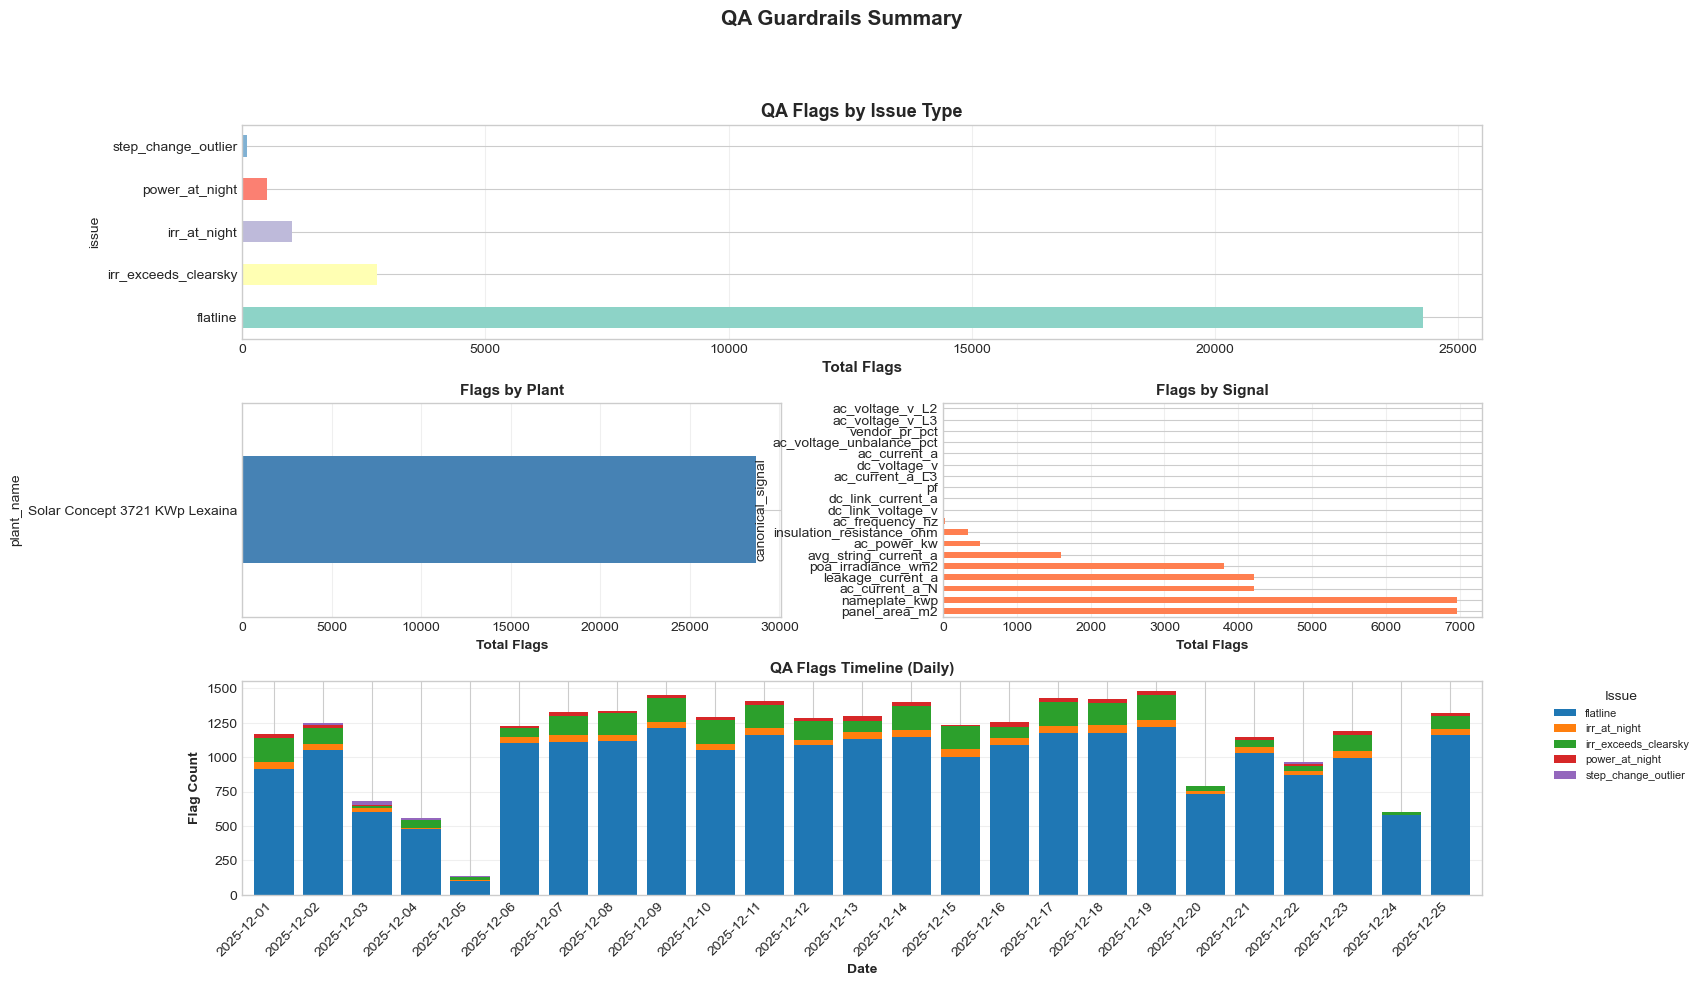

In [269]:
import seaborn as sns


def plot_qa_overview(qa_summary, qa_flags, figsize=(16, 10)):
    """Comprehensive QA visualization dashboard."""
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Issue type bar chart
    ax1 = fig.add_subplot(gs[0, :])
    issue_totals = qa_summary.groupby("issue")["count"].sum().sort_values(ascending=False)
    colors = plt.cm.Set3(range(len(issue_totals)))
    issue_totals.plot(kind="barh", ax=ax1, color=colors)
    ax1.set_xlabel("Total Flags", fontsize=11, weight="bold")
    ax1.set_title("QA Flags by Issue Type", fontsize=13, weight="bold")
    ax1.grid(axis="x", alpha=0.3)

    # 2. Flags per plant
    ax2 = fig.add_subplot(gs[1, 0])
    plant_totals = qa_summary.groupby("plant_name")["count"].sum().sort_values(ascending=False)
    if len(plant_totals) > 0:
        plant_totals.plot(kind="barh", ax=ax2, color="steelblue")
        ax2.set_xlabel("Total Flags", fontsize=10, weight="bold")
        ax2.set_title("Flags by Plant", fontsize=11, weight="bold")
        ax2.grid(axis="x", alpha=0.3)

    # 3. Flags per signal type
    ax3 = fig.add_subplot(gs[1, 1])
    signal_totals = (
        qa_summary.groupby("canonical_signal")["count"].sum().sort_values(ascending=False)
    )
    if len(signal_totals) > 0:
        signal_totals.plot(kind="barh", ax=ax3, color="coral")
        ax3.set_xlabel("Total Flags", fontsize=10, weight="bold")
        ax3.set_title("Flags by Signal", fontsize=11, weight="bold")
        ax3.grid(axis="x", alpha=0.3)

    # 4. Timeline of flags (if enough data)
    ax4 = fig.add_subplot(gs[2, :])
    if not qa_flags.empty and len(qa_flags) > 1:
        qa_flags_copy = qa_flags.copy()
        qa_flags_copy["date"] = pd.to_datetime(qa_flags_copy["ts"]).dt.date
        daily_counts = qa_flags_copy.groupby(["date", "issue"]).size().unstack(fill_value=0)
        daily_counts.plot(kind="bar", stacked=True, ax=ax4, width=0.8)
        ax4.set_xlabel("Date", fontsize=10, weight="bold")
        ax4.set_ylabel("Flag Count", fontsize=10, weight="bold")
        ax4.set_title("QA Flags Timeline (Daily)", fontsize=11, weight="bold")
        ax4.legend(title="Issue", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
        ax4.grid(axis="y", alpha=0.3)
        # Rotate x labels for readability
        if len(daily_counts) > 20:
            ax4.set_xticks(range(0, len(daily_counts), max(1, len(daily_counts) // 20)))
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.suptitle("QA Guardrails Summary", fontsize=15, weight="bold", y=0.995)
    plt.tight_layout()
    plt.show()


# Generate overview dashboard
plot_qa_overview(qa_summary, qa_flags)

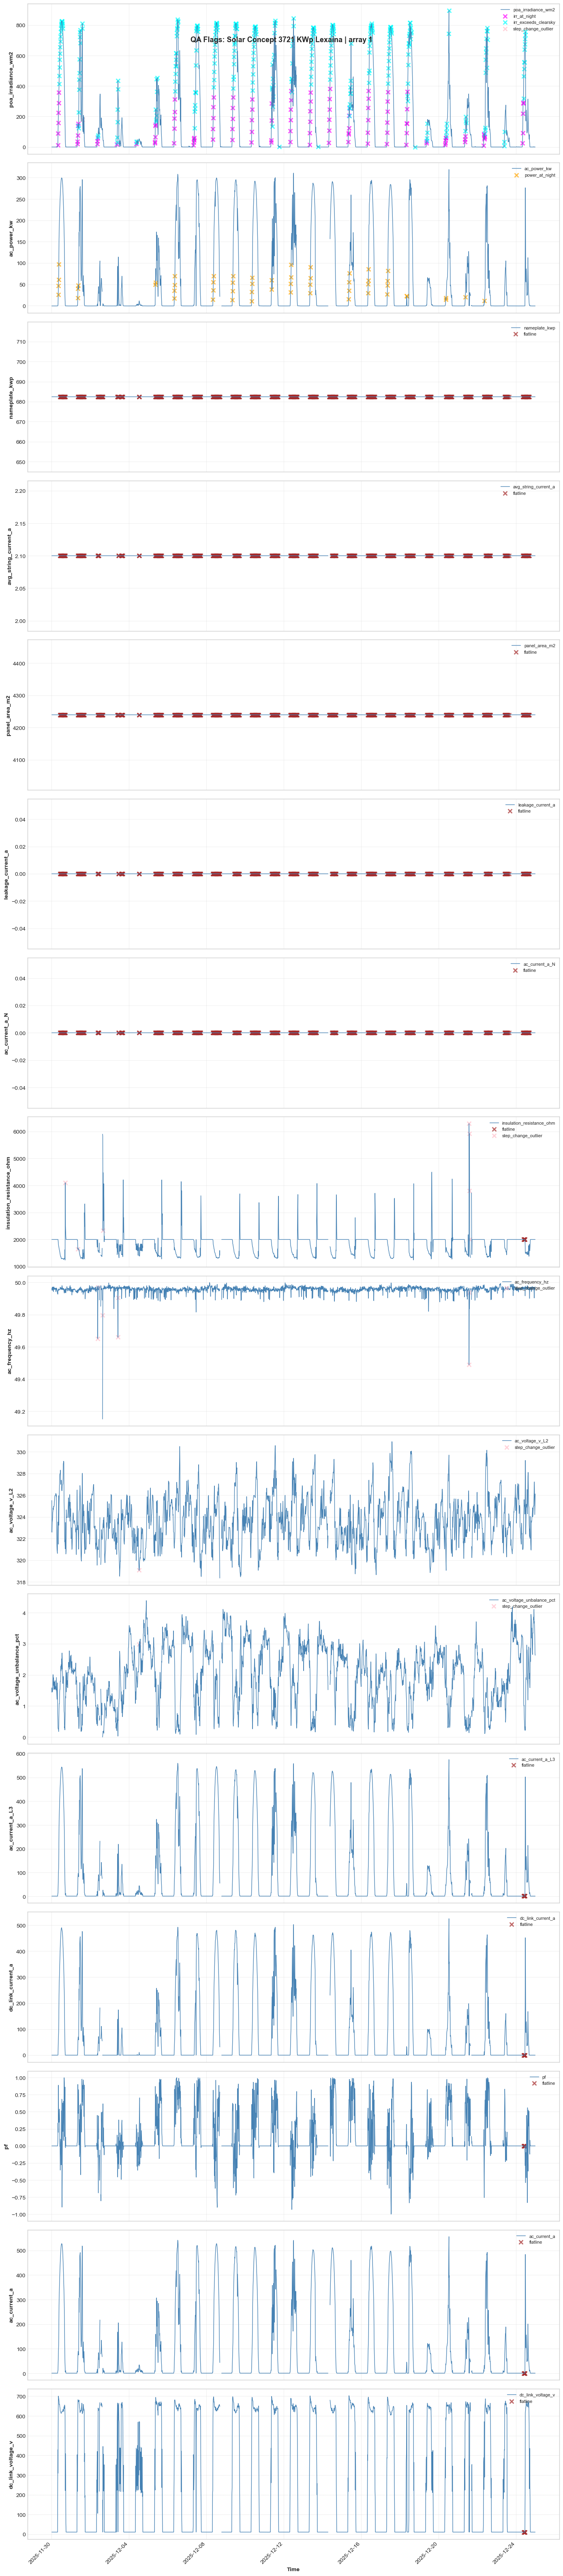

In [271]:
def plot_component_qa_details(qa_flags, plant_name, component_type, component_id, scada_rs):
    """Plot QA flags overlaid on signal timeseries for a specific component."""
    import matplotlib.dates as mdates

    # Filter to component
    comp_flags = qa_flags[
        (qa_flags["plant_name"] == plant_name)
        & (qa_flags["component_type"] == component_type)
        & (qa_flags["component_id"] == component_id)
    ].copy()

    comp_data = scada_rs[
        (scada_rs["plant_name"] == plant_name)
        & (scada_rs["component_type"] == component_type)
        & (scada_rs["component_id"] == component_id)
    ].copy()

    if comp_flags.empty:
        print(f"No QA flags for {plant_name} | {component_type} {component_id}")
        return

    signals = comp_flags["canonical_signal"].unique()
    fig, axes = plt.subplots(len(signals), 1, figsize=(14, 4 * len(signals)), sharex=True)
    if len(signals) == 1:
        axes = [axes]

    for ax, sig in zip(axes, signals, strict=False):
        sig_data = comp_data[comp_data["canonical_signal"] == sig].copy()
        sig_flags = comp_flags[comp_flags["canonical_signal"] == sig].copy()

        if "ts" in sig_data.columns:
            sig_data["ts"] = pd.to_datetime(sig_data["ts"])
            sig_data = sig_data.set_index("ts").sort_index()

        # Plot signal
        ax.plot(sig_data.index, sig_data["value_rs"], label=sig, linewidth=1, color="steelblue")

        # Overlay flags by issue type
        issue_colors = {
            "irr_negative": "red",
            "power_at_night": "orange",
            "temp_out_of_bounds": "purple",
            "flatline": "brown",
            "step_change_outlier": "pink",
            "mad_outlier": "yellow",
            "irr_at_night": "magenta",
            "irr_exceeds_clearsky": "cyan",
        }

        for issue, issue_flags in sig_flags.groupby("issue"):
            ax.scatter(
                pd.to_datetime(issue_flags["ts"]),
                issue_flags["value"],
                s=50,
                alpha=0.7,
                label=issue,
                color=issue_colors.get(issue, "gray"),
                marker="x",
                linewidths=2,
            )

        ax.set_ylabel(f"{sig}", fontsize=10, weight="bold")
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axes[-1].set_xlabel("Time", fontsize=10, weight="bold")
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.suptitle(
        f"QA Flags: {plant_name} | {component_type} {component_id}", fontsize=13, weight="bold"
    )
    plt.tight_layout()
    plt.show()


# Example usage (adjust to your actual component)
plot_component_qa_details(
    qa_flags,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    component_id="1",
    scada_rs=scada_rs,
)

In [241]:
from pv_fleet_health.dq import dq_report_fleet

dq_report = dq_report_fleet(scada_rs, cfg)
print("DQ report rows:", len(dq_report))
display(dq_report.sort_values("dq_score").head(10))
display(dq_report.sort_values("dq_score", ascending=False).head(10))

save_parquet(dq_report, str(paths.stage_dir / "dq_report.parquet"))

DQ report rows: 1


plant_name  poa_missing_frac_day  \
0  Solar Concept 3721 KWp Lexaina                   0.0   

   tmod_missing_frac_day  p_missing_frac_day  poa_oob_frac  tmod_oob_frac  \
0                    0.0            0.012788           0.0            0.0   

   pf_oob_frac  poa_stuck_frac  tmod_stuck_frac  counter_reset_frac  \
0          0.0        0.377083              0.0            0.509037   

   completeness_score  plausibility_score  stuck_score  counter_score  \
0            0.978687                 1.0          0.5            0.0   

   dq_score monitoring_confidence  
0  0.619672                   Low

plant_name  poa_missing_frac_day  \
0  Solar Concept 3721 KWp Lexaina                   0.0   

   tmod_missing_frac_day  p_missing_frac_day  poa_oob_frac  tmod_oob_frac  \
0                    0.0            0.012788           0.0            0.0   

   pf_oob_frac  poa_stuck_frac  tmod_stuck_frac  counter_reset_frac  \
0          0.0        0.377083              0.0            0.509037   

   completeness_score  plausibility_score  stuck_score  counter_score  \
0            0.978687                 1.0          0.5            0.0   

   dq_score monitoring_confidence  
0  0.619672                   Low